# Анализ данных вакансий HH.ru

### 1. Описание проекта

#### Цель проекта: 
Выявить различия в предлагаемых вакансиях для Аналитиков данных и Системных аналитиков.

Это поможет сформировать полное представление о рынке труда для данных профессий.

Датасеты vacancies_da (1).xlsx и vacancies_sa.xlsx сложены в проекте рядом с тетрадкой.


#### Гипотезы:
Гипотеза 1: Аналитики данных и системные аналитики имеют разные уровни зарплат.

Гипотеза 2: В разных регионах регионах требуются разные аналитики.

In [3]:
!pip install beautifulsoup4 requests
!pip install matplotlib wordcloud
!pip install pandas plotly

# библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import requests
import seaborn as sns

from collections import Counter
from bs4 import BeautifulSoup
from IPython.display import display
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from wordcloud import WordCloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### 2. Предобработка данных
Цель: Подготовить данные для анализа.

In [5]:
# загрузка файлов (рядом с тетрадкой)
vacancies_da = pd.read_excel('vacancies_da (1).xlsx')
vacancies_sa = pd.read_excel('vacancies_sa.xlsx')

# добавим функции ИТ перед слиянием для отличия
vacancies_da['function'] = 'Аналитик данных'
vacancies_sa['function'] = 'Системный аналитик'
vacancies = pd.concat([vacancies_da, vacancies_sa], ignore_index=True)

In [6]:
# 64bit в 32bit
if vacancies.select_dtypes(include=['int64']).shape[1] > 0:
    vacancies[vacancies.select_dtypes(include=['int64']).columns] = vacancies.select_dtypes(include=['int64']).astype('int32')
if vacancies.select_dtypes(include=['float64']).shape[1] > 0:
    vacancies[vacancies.select_dtypes(include=['float64']).columns] = vacancies.select_dtypes(include=['float64']).astype('float32')

# верность дат
vacancies['published_at'] = pd.to_datetime(vacancies['published_at'], errors='coerce', format='%Y-%m-%d').astype('datetime64[ns]')

# типы стобцов
vacancies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3716 entries, 0 to 3715
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int32         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        882 non-null    object        
 7   area                              3716 non-null   object        
 8   experience                        3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule                          3716 non-null 

Уменьшили за счёт битности объём памяти. Обнаружены частично незаполенные столбцы.

In [8]:
# пропуски
missing_values = vacancies.isnull().sum()
display(missing_values[missing_values > 0])

department                          2834
salary_from                         3012
salary_to                           3209
key_skills_from_key_skills_field    1349
hard_skills_from_description        2728
soft_skills_from_description        1701
dtype: int64

Все частично незаполненные столбцы из-за своего типа и назначения не позволяют автоматически заполнить пропуски без внесения недостоверности. Оставим пока их в покое.

#### Очистка данных

In [11]:
# дубликаты
duplicates_count = vacancies.duplicated().sum()
display(f"Дубликатов: {duplicates_count}")

# все строки
string_columns = vacancies.select_dtypes(include=['object']).columns
for col in string_columns:
    vacancies[f"{col}_low"] = vacancies[col].str.strip().str.lower()

columns_low = [f"{col}_low" for col in string_columns]  # обработанные столбцы
# посчитаем неявные, потом грохнем
duplicates_count = vacancies.duplicated(subset=columns_low).sum()
display(f"Неявных дубликатов: {duplicates_count}")
vacancies = vacancies.drop_duplicates(subset=columns_low)
vacancies = vacancies.drop(columns=columns_low)

'Дубликатов: 0'

'Неявных дубликатов: 0'

Полные дубликаты строк не обнаружены.

In [13]:
# разбросы
display(vacancies.drop(columns=['id']).describe())

published_at    salary_from      salary_to
count                           3716     704.000000     507.000000
mean   2024-06-05 00:29:21.445640448  132074.703125  192250.125000
min              2024-02-13 21:45:51      50.000000   20000.000000
25%    2024-05-13 07:52:41.750000128   75000.000000  100000.000000
50%       2024-06-27 13:32:52.500000  120000.000000  180000.000000
75%    2024-07-05 10:31:06.750000128  181750.000000  280000.000000
max              2024-07-09 12:47:11  398000.000000  580000.000000
std                              NaN   72442.617188  106554.765625

Минимальная зарплата от вызвает подозрение. Очевидно, что 50 р/м - это ошибочное значение. Ограничем зарплаты от МРОТ по Росссии (19242 р/м), некорректные строки удалим. Минимальная зарплата до - грустная, но вполне возможна. Максимальные зарплаты не выглядят фантастическими - к ним будем стремиться.

In [15]:
MROT = 19242
vacancies = vacancies[(vacancies['salary_from'] >= MROT) | (vacancies['salary_from'].isnull())]
display(vacancies.describe())

id                   published_at    salary_from  \
count  3.714000e+03                           3714     702.000000   
mean   9.871344e+07  2024-06-05 00:26:26.953958144  132450.515625   
min    5.241017e+07            2024-02-13 21:45:51   20000.000000   
25%    9.616099e+07  2024-05-13 07:58:57.750000128   75000.000000   
50%    9.920377e+07     2024-06-27 13:32:52.500000  120000.000000   
75%    1.023778e+08  2024-07-05 10:28:39.750000128  185250.000000   
max    1.035847e+08            2024-07-09 12:47:11  398000.000000   
std    4.487592e+06                            NaN   72201.890625   

           salary_to  
count     505.000000  
mean   192140.234375  
min     20000.000000  
25%    100000.000000  
50%    180000.000000  
75%    280000.000000  
max    580000.000000  
std    106483.640625

#### Нормализация данных

In [17]:
# показать таки все столбцы нам
pd.set_option('display.max_columns', None)

# обработанные данные
display(vacancies.sample(5))  # , random_state=5))

id                                               name  \
1201   97237821                              Аналитик данных (МСБ)   
1821  100403398            Системный аналитик (Solution Architect)   
3658   99142090                          Системный аналитик Middle   
237   101324992  Data Analyst (Data Science и клиентская аналит...   
1983  101433244                                 Системный аналитик   

            published_at                    alternate_url      type  \
1201 2024-04-17 15:46:03   https://hh.ru/vacancy/97237821  Открытая   
1821 2024-07-08 18:26:42  https://hh.ru/vacancy/100403398  Открытая   
3658 2024-07-09 12:09:05   https://hh.ru/vacancy/99142090  Открытая   
237  2024-06-05 10:42:00  https://hh.ru/vacancy/101324992  Открытая   
1983 2024-07-05 17:58:05  https://hh.ru/vacancy/101433244  Открытая   

               employer               department             area  \
1201         МТС Финтех  МТС Банк. Головной офис           Москва   
1821             NGENIX                      NaN           Москва   
3658       Megagroup.ru                      NaN  Санкт-Петербург   
237                СБЕР       Сбер для экспертов           Москва   
1983  Сеть аптек Апрель                      NaN        Краснодар   

               experience                                         key_skills  \
1201  Junior+ (1-3 years)  ['Инструменты BI', 'MS SQL', 'Математическая с...   
1821   Middle (3-6 years)        ['UML', 'Системный анализ', 'Документация']   
3658  Junior+ (1-3 years)  ['REST API', 'русский язык', 'SaaS', 'UML', 'C...   
237    Middle (3-6 years)                                                 []   
1983  Junior+ (1-3 years)  ['Складская логистика', 'MS SQL', 'SQL', 'Инфо...   

         schedule        employment  \
1201  Полный день  Полная занятость   
1821  Полный день  Полная занятость   
3658  Полный день  Полная занятость   
237   Полный день  Полная занятость   
1983  Полный день  Полная занятость   

                                            description  \
1201  мтс финтех – одно из самых технологичных напра...   
1821  ngenix — лидер на рынке облачных решений и раз...   
3658  описание компании: привет! мы - проект taptop,...   
237   в команду «data science и клиентская аналитика...   
1983  федеральная сеть аптек «апрель» — работаем с з...   

                                 description_lemmatized  salary_from  \
1201  мтс финтех технологичный направление экосистем...     120000.0   
1821  ngenix лидер рынок облачный решение разработчи...          NaN   
3658  описание компания привет проект taptop разраба...          NaN   
237   команда data science клиентский аналитика корп...          NaN   
1983  федеральный сеть аптека апрель работать забота...     150000.0   

      salary_to                 salary_bin  \
1201        NaN              ЗП не указана   
1821        NaN              ЗП не указана   
3658   150000.0  От 100 тысяч до 200 тысяч   
237         NaN              ЗП не указана   
1983        NaN              ЗП не указана   

                       key_skills_from_key_skills_field  \
1201  Математическая статистика, MS SQL, MS Excel, И...   
1821                              Системный анализ, UML   
3658  Аналитическое мышление, Системный анализ, BPMN...   
237                                                 NaN   
1983  MS SQL, SQL, Информационные технологии, Оптими...   

     hard_skills_from_description soft_skills_from_description  \
1201                          NaN                          NaN   
1821                          NaN                 Документация   
3658                          NaN                 Коммуникация   
237                           NaN                          NaN   
1983                          NaN                 Документация   

                function  
1201     Аналитик данных  
1821  Системный аналитик  
3658  Системный аналитик  
237      Аналитик данных  
1983  Системный аналитик

В некоторых столбцах указаны кортежи значений. Такое хранение множественных данных допустимо при соблюдении установленного синтаксиса. 1-я нормальная форма уже не является обязательным требованием, однако я предпочитаю классический реляционный подход. Подготовим справочники повторяющихся значений и соединительные таблицы для связи с ними.

In [19]:
# столбцы с кортежами
cortage_columns = {
    'key_skills': ',',  # списки
    'key_skills_from_key_skills_field': ',',  # разделитель - запятая
    'hard_skills_from_description': ',',  # разделитель - запятая
    'soft_skills_from_description': ',',  # разделитель - запятая
    # исключим из словаря лемматизированное описание - его обрботка занимает ~20 мин
    # выгрузил отдельно, пока не понятно пригодится ли оно, но мы ко всему готовы
    # 'description_lemmatized': ' '  # разделитель - пробел
}

# делим правильно
def split_no_in_brackets(text, delimiter):
    # регулярка для разделения - игнор запятых внутри скобок
    # жесть конечно - инопланетный язык, коллега помог добить
    # шаблон для регулярки - сохраняем группы слов, не разбиваем фразы с пробелами
    pattern = r'(?:[^' + re.escape(delimiter) + r']+|\(.*?\))'
    # совпадения
    matches = re.findall(pattern, text)
    # в список, убираем пробелы
    result = [match.strip("'[] ").lower() for match in matches if match.strip("'[] ")]
    return result

# перебираем столбцы для записи в копитю
vacancies_norm = vacancies.copy()
for column, delimiter in cortage_columns.items():
    display(f'Обрабатывается {column}..')  # типа лог, что всё идёт по плану..
    # всё - в списки - убираем лишнее и в нижн.регистр

    # пришлось с отладкой
    def process_item(x):
        try:
            if pd.isnull(x) or x is None:  # пустота
                return []
            elif isinstance(x, list):  # уже список
                return x
            elif isinstance(x, str):  # строка
                return split_no_in_brackets(x, delimiter)
            else:
                display(f"Непредвиденный тип данных в столбце {column}: {type(x)}, значение: {x}")
                return []
        except Exception as e:
            display(f"Ошибка при обработке значения {x}: {e}")
            return []

    # перепишем в те же столбцы, чтобы съэкономить память
    vacancies_norm[column] = vacancies_norm[column].apply(process_item)
    # display(vacancies_norm.sample(5))

    # соберём все скилы в уникальный надор
    unique_values = set(item for item_list in vacancies_norm[column] for item in item_list)
    if unique_values:
	    # сгенерим из него справочник-словарь в дф с помощью глобалз
        globals()[f'{column}_dict'] = pd.DataFrame({
            f'{column}_id': range(1, len(unique_values) + 1),
            f'{column}_name': list(unique_values)
        })
        display(f"Справочник {column} создан с {len(unique_values)} уникальными значениями.")
    else:
        display(f"Для столбца {column} не найдено уникальных значений.")
        continue

    # соединительная таблица сначала как список, потом дф
    links = []
    # устроим перебор строк только нужными столбцами
    for idx, row in vacancies_norm[['id'] + list(cortage_columns.keys())].iterrows():
        # display(row)
        for item in row[column]:
            # display(item)
            if row[column] != 'id':
                item_id = globals()[f'{column}_dict'].loc[
                    globals()[f'{column}_dict'][f'{column}_name'] == item, f'{column}_id'
                ].values[0]  # ид элемента
                links.append({'vacancy_id': row['id'], f'{column}_id': item_id})  # ид ваканси
    # линки также в дф
    if links:
        globals()[f'{column}_link'] = pd.DataFrame(links)
        display(f"Соединительная таблица {column} создана с {len(links)} записей.")
    else:
        display(f"Для столбца {column} не создано соединительных данных.")

# сохраним гиганта description_lemmatized рядом с тетрадкой
# description_lemmatized_dict.to_csv('description_lemmatized_dict.csv', index=False)
# description_lemmatized_link.to_csv('description_lemmatized_link.csv', index=False)

# загрузим ранее сохранённое description_lemmatized
description_lemmatized_dict = pd.read_csv('description_lemmatized_dict.csv')
description_lemmatized_link = pd.read_csv('description_lemmatized_link.csv')

'Обрабатывается key_skills..'

'Справочник key_skills создан с 1519 уникальными значениями.'

'Соединительная таблица key_skills создана с 20043 записей.'

'Обрабатывается key_skills_from_key_skills_field..'

'Справочник key_skills_from_key_skills_field создан с 1510 уникальными значениями.'

'Соединительная таблица key_skills_from_key_skills_field создана с 16557 записей.'

'Обрабатывается hard_skills_from_description..'

'Справочник hard_skills_from_description создан с 5 уникальными значениями.'

'Соединительная таблица hard_skills_from_description создана с 1030 записей.'

'Обрабатывается soft_skills_from_description..'

'Справочник soft_skills_from_description создан с 15 уникальными значениями.'

'Соединительная таблица soft_skills_from_description создана с 2541 записей.'

In [20]:
# посмотрим что да как
display("description_lemmatized:")
display(description_lemmatized_dict.sample(5, random_state=5))
display(description_lemmatized_link.sample(5, random_state=5))
for column in cortage_columns:
    display(f"{column}:")
    display(globals()[f'{column}_dict'].sample(5, random_state=5))
    display(globals()[f'{column}_link'].sample(5, random_state=5))

'description_lemmatized:'

description_lemmatized_id description_lemmatized_name
7282                        7283             инкрементальный
9086                        9087                      тукать
10547                      10548               действительно
2000                        2001              просканировать
15154                      15155                 выплачивать

vacancy_id  description_lemmatized_id
237152    97431803                      10376
343350   100046399                       5449
187817    96347557                       5247
39100    101235491                       3013
107212    94248660                       3013

'key_skills:'

key_skills_id                       key_skills_name
665             666  анализ и документирование информации
1096           1097                                  roas
334             335                                amocrm
253             254                         понимание cdc
1169           1170              сбор и анализ информации

vacancy_id  key_skills_id
134     100161630            926
11610   102839078           1156
4323     95985590            183
16790    85659981            909
5478     97215690            428

'key_skills_from_key_skills_field:'

key_skills_from_key_skills_field_id  \
591                                   592   
1073                                 1074   
1311                                 1312   
1416                                 1417   
269                                   270   

     key_skills_from_key_skills_field_name  
591                   разработка дэшбордов  
1073                                 ci\cd  
1311                           sql-запросы  
1416                              internet  
269                  работа с требованиями

vacancy_id  key_skills_from_key_skills_field_id
13971    86725522                                  180
13722   103583874                                  506
11038   103049961                                  521
12965   103479684                                 1269
12944   103476079                                  849

'hard_skills_from_description:'

hard_skills_from_description_id hard_skills_from_description_name
4                                5                        confluence
0                                1                            pandas
1                                2         математическая статистика
2                                3                     google sheets
3                                4                    юнит-экономика

vacancy_id  hard_skills_from_description_id
34    100702507                                1
33    100694553                                5
478   100692139                                5
614   102819978                                5
236    95965137                                1

'soft_skills_from_description:'

soft_skills_from_description_id soft_skills_from_description_name
5                                 6           презентация результатов
1                                 2                      коммуникация
7                                 8                      документация
2                                 3                     проактивность
10                               11                        переговоры

vacancy_id  soft_skills_from_description_id
295    95071686                                2
86    101112936                                8
466    97166243                                2
226    94012481                                4
346    95813844                                8

In [21]:
# проверим кол-во нормализованных строк - было после очистки 3714
display(vacancies_norm.shape[0])

3714

Ничего не пропало. Справочники и соединительные таблицы к нормализованным кортежным столбцам готовы. Кортежные столбцы приведены к единому списочному виду.

#### Обогащение данных

In [24]:
# уникальные значения
display(sorted(vacancies['experience'].dropna().unique()))

['Junior (no experince)',
 'Junior+ (1-3 years)',
 'Middle (3-6 years)',
 'Senior (6+ years)']

Обратим внимание на категориальный столбец experience, который также имеет и явный количественный характер, а именно по его значениям можно одноздначно определить степень экспертности.

Значения правильно сортируются соглсано уровню эспертности, поэтому добавление отдельного столбца с числовым значением не имеет смысла

И напоследок остаётся столбец area. Рассмотрим его подробнее

In [28]:
display(vacancies['area'].dropna().sample(5))  # , random_state=5))

1508    Москва
1063    Москва
1454    Москва
60      Москва
1051    Москва
Name: area, dtype: object

Попробуем обогатить данные ригионами и округами. Некоторые города уже с регионами, например, Иваново (Ивановская область).

Недостающую геоинформацию получим со странцы википедии Список городов России

In [30]:
# страница вики
url = "https://ru.wikipedia.org/wiki/Список_городов_России"

# загружаем
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# из кода страницы видно, что нужна таблица standard sortable
table = soup.find("table", {"class": "standard sortable"})

# парсим данные
cities = []
rows = table.find_all("tr")[1:]  # без заголовка таблицы
for row in rows:
    columns = row.find_all("td")
    city = columns[2].text.strip()  # город
    region = columns[3].text.strip()  # регион
    district = columns[4].text.strip()  # округ
    population = int(columns[5].text.strip().replace(' ', '').split('[')[0])   # население
        
    cities.append({
        "city": city,
        "region": region,
        "district": district,
        "population": population
    })

# в дф
cities_dict = pd.DataFrame(cities)
display(cities_dict.sample(5, random_state=5))
# display(cities_dict[cities_dict['city'] == 'Таганрог'])


city                region     district  population
431     Козьмодемьянск              Марий Эл  Приволжский       19731
366  Каменск-Уральский  Свердловская область    Уральский      164192
427            Когалым   Ханты-Мансийский АО    Уральский       61441
746              Пермь         Пермский край  Приволжский     1034002
732             Оханск         Пермский край  Приволжский        6430

Добавим столбцы city, region, district, population и заполним данными из вакансий при наличии. Далее дополним недостающие данные из справочника из википедии, где это возможно.

In [32]:
# пустые столбцы
vacancies_norm['city'] = ''
vacancies_norm['region'] = ''
vacancies_norm['district'] = ''
vacancies_norm['population'] = ''

# столбец area в деле
for index, row in vacancies_norm.iterrows():
    area = row['area']
    if '(' in area:  # есть скобки
        city, region = area.split('(', 1)  # делим по первой скобке
        vacancies_norm.at[index, 'city'] = city.strip()
        vacancies_norm.at[index, 'region'] = region.replace(')', '').strip()  # закрывающую скобку в топку
    else:  # Если скобок нет
        vacancies_norm.at[index, 'city'] = area.strip()  # Заполняем только город

# недостающие данные
for index, row in vacancies_norm.iterrows():
    if vacancies_norm.at[index, 'region']:
        match = cities_dict.loc[(cities_dict['city'] == row['city']) & (cities_dict['region'] == row['region'])]
    else:
        match = cities_dict.loc[cities_dict['city'] == row['city']]
        if not match.empty:  # есть ли совпадения
            vacancies_norm.at[index, 'region'] = match.iloc[0]['region']
    if not match.empty:  # есть ли совпадения
        vacancies_norm.at[index, 'district'] = match.iloc[0]['district']
        vacancies_norm.at[index, 'population'] = match.iloc[0]['population']

display(vacancies_norm.sample(5))  # , random_state=5))
display(vacancies_norm.shape[0])

id                                               name  \
927    95984164  Академический руководитель программы "Аналитик...   
1382   97979996       Аналитик данных в группу платежной аналитики   
697    94969972                                 Data analyst (RTB)   
2095  101874420                         Системный аналитик e-staff   
1072   96647308  Ведущий аналитик данных, Группа операционной а...   

            published_at                    alternate_url      type  \
927  2024-04-02 12:44:06   https://hh.ru/vacancy/95984164  Открытая   
1382 2024-04-26 11:25:19   https://hh.ru/vacancy/97979996  Открытая   
697  2024-04-14 14:41:06   https://hh.ru/vacancy/94969972  Открытая   
2095 2024-07-09 10:23:13  https://hh.ru/vacancy/101874420  Открытая   
1072 2024-04-22 18:36:12   https://hh.ru/vacancy/96647308  Открытая   

                                               employer  \
927   Национальный исследовательский университет Выс...   
1382                                             Яндекс   
697                                         Адверт Лабс   
2095                          ПСБ (ПАО «Промсвязьбанк»)   
1072                                               Ozon   

                          department             area          experience  \
927                              NaN           Москва  Middle (3-6 years)   
1382                          Яндекс  Санкт-Петербург  Middle (3-6 years)   
697                              NaN  Санкт-Петербург  Middle (3-6 years)   
2095         ПАО «Промсвязьбанк», ИТ           Москва  Middle (3-6 years)   
1072  Ozon Информационные технологии           Москва  Middle (3-6 years)   

                                             key_skills          schedule  \
927                                                  []  Удаленная работа   
1382                        [python, документация, sql]       Полный день   
697   [анализ данных, коммуникация, rtb, документаци...  Удаленная работа   
2095  [ms sql, e-staff, html, javascript, css, комму...       Полный день   
1072                                           [pandas]  Удаленная работа   

            employment                                        description  \
927   Полная занятость  факультет компьютерных наук вышки — молодой и ...   
1382  Полная занятость  траст — один из наших внутренних сервисов — от...   
697   Полная занятость  в адверт лабс мы занимаемся интернет-рекламой....   
2095  Полная занятость  ключевые задачи:    развитие по e-staff рекрут...   
1072  Полная занятость  чем занимается команда:  cозданием и поддержко...   

                                 description_lemmatized  salary_from  \
927   факультет компьютерный наука вышка молодой сов...          NaN   
1382  траст наш внутренний сервис отвечать проведени...          NaN   
697   адверт лабс заниматься интернет реклама наш ос...     180000.0   
2095  ключевой задача развитие e staff рекрутер част...          NaN   
1072  заниматься команда создание поддержка data про...          NaN   

      salary_to     salary_bin  \
927         NaN  ЗП не указана   
1382        NaN  ЗП не указана   
697         NaN  ЗП не указана   
2095        NaN  ЗП не указана   
1072        NaN  ЗП не указана   

                       key_skills_from_key_skills_field  \
927                                                  []   
1382                                      [sql, python]   
697   [анализ данных, rtb, programmatic, data analysis]   
2095  [ms sql, postgresql, javascript, html, css, e-...   
1072                                                 []   

     hard_skills_from_description  soft_skills_from_description  \
927                            []                            []   
1382                           []                [документация]   
697                  [confluence]  [коммуникация, документация]   
2095                           []                [коммуникация]   
1072                     [pandas]                            []   

                function 

3714

Ничего не потеряно. Данные обогащены географией, где это возжно. Эти трансформации делают данные более структурированными, полными и готовыми для дальнейшего  исследовательского анализа..

#### Выводы:
Вакансии аналитиков данных и системных аналитиков концентрируются в крупных городах и регионах, где представлены крупные IT-компании.
Москва и Санкт-Петербург лидируют по числу вакансий, занимая значительную долю в общем количестве.
Среди других крупных IT-регионов выделяются Екатеринбург, Казань, и Новосибирск.

### 3. Исследовательский анализ данных (EDA)
Цель: Получить первичные выводы о данных.

Ранее для проверки корректности предобработок мы уже подсчитали, что количество корректных вакансий = 3714.

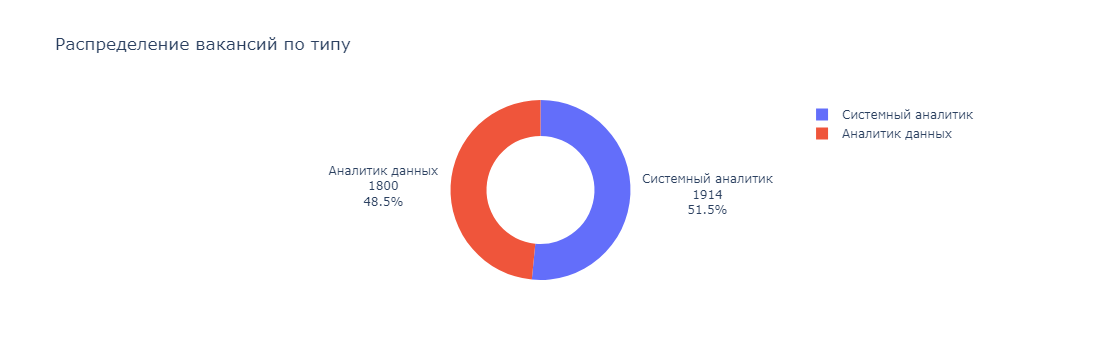

In [37]:
# распределение вакансий по типу
vacancy_distribution = vacancies_norm['function'].value_counts().reset_index()
vacancy_distribution.columns = ['function', 'count']

fig = px.pie(
    vacancy_distribution,
    names='function',
    values='count',
    title="Распределение вакансий по типу",
    hole=0.6  # дырка
)
fig.update_traces(textinfo='percent+label+value')
fig.show()

Аналитиков данных и системных требуется примерно поровну.

Минимальная зарплата (от)  Минимальная зарплата (до)  \
function                                                                   
Аналитик данных                       25000.0                    26000.0   
Системный аналитик                    20000.0                    20000.0   

                    Медианная зарплата (от)  Медианная зарплата (до)  \
function                                                               
Аналитик данных                    100000.0                 120000.0   
Системный аналитик                 150000.0                 200000.0   

                    Средняя зарплата (от)  Средняя зарплата (до)  \
function                                                           
Аналитик данных             110869.804688          154322.218750   
Системный аналитик          146882.921875          207855.921875   

                    Максимальная зарплата (от)  Максимальная зарплата (до)  
function                                                                    
Аналитик данных                       398000.0                    497500.0  
Системный аналитик                    350000.0                    450000.0

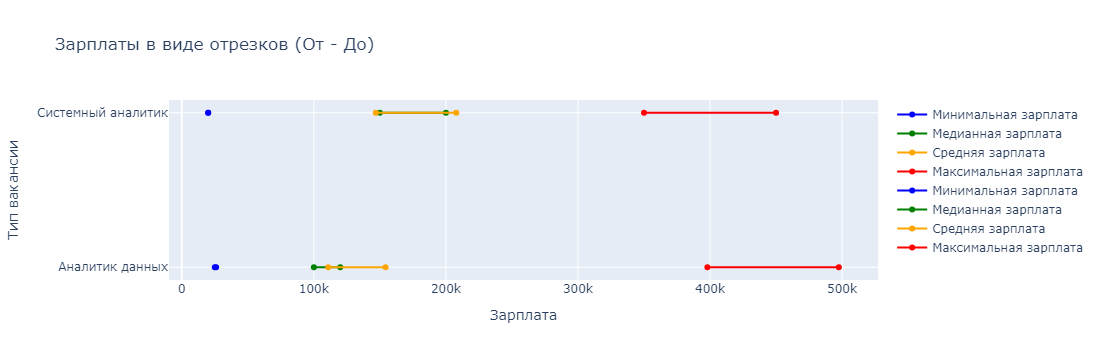

In [39]:
# вакансии с указанными зарплатами
vacancies_with_salary = vacancies_norm.dropna(subset=['salary_from', 'salary_to'])

salary_stats_by_function = vacancies_with_salary.groupby('function')[['salary_from', 'salary_to']].agg(['min', 'median', 'mean', 'max'])
salary_stats_by_function.columns = ['_'.join(col) for col in salary_stats_by_function.columns]
salary_stats_by_function.rename(columns={
    'salary_from_min': 'Минимальная зарплата (от)',
    'salary_to_min': 'Минимальная зарплата (до)',
    'salary_from_median': 'Медианная зарплата (от)',
    'salary_to_median': 'Медианная зарплата (до)',
    'salary_from_mean': 'Средняя зарплата (от)',
    'salary_to_mean': 'Средняя зарплата (до)',
    'salary_from_max': 'Максимальная зарплата (от)',
    'salary_to_max': 'Максимальная зарплата (до)',
}, inplace=True)
column_order = [
    'Минимальная зарплата (от)', 'Минимальная зарплата (до)', 'Медианная зарплата (от)', 'Медианная зарплата (до)',
    'Средняя зарплата (от)', 'Средняя зарплата (до)', 'Максимальная зарплата (от)', 'Максимальная зарплата (до)'
]
salary_stats_by_function = salary_stats_by_function[column_order]
display(salary_stats_by_function)

salary_stats_by_function = salary_stats_by_function.reset_index()

# отрезки
fig = go.Figure()
for _, row in salary_stats_by_function.iterrows():
    fig.add_trace(go.Scatter(
        x=[row['Минимальная зарплата (от)'], row['Минимальная зарплата (до)']],
        y=[row['function'], row['function']],
        mode='lines+markers',
        name='Минимальная зарплата',
        line=dict(color='blue', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=[row['Медианная зарплата (от)'], row['Медианная зарплата (до)']],
        y=[row['function'], row['function']],
        mode='lines+markers',
        name='Медианная зарплата',
        line=dict(color='green', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=[row['Средняя зарплата (от)'], row['Средняя зарплата (до)']],
        y=[row['function'], row['function']],
        mode='lines+markers',
        name='Средняя зарплата',
        line=dict(color='orange', width=2)
    ))
    fig.add_trace(go.Scatter(
        x=[row['Максимальная зарплата (от)'], row['Максимальная зарплата (до)']],
        y=[row['function'], row['function']],
        mode='lines+markers',
        name='Максимальная зарплата',
        line=dict(color='red', width=2)
    ))
fig.update_layout(
    title='Зарплаты в виде отрезков (От - До)',
    xaxis_title='Зарплата',
    yaxis_title='Тип вакансии',
    yaxis=dict(categoryorder='total ascending'),  # упорядочивание вакансий
    showlegend=True
)
fig.show()

Получился очень интересный результат. Оказывается минимальная ЗП аналитиков примерно одинаковая, средние ЗП выше у системных аналитиков, а максимальная выше у аналитиков данных. Получается просто аналитиком данных быть невыгодно, надо быть сразу хорошим 😊

Вероятно ведущие системные аналитики ценее данных, но главные аналитики данных ценнее системных. Проверим эту гипотезу позже в сравнительном аналзе, разбив функции на уровни экспертности.

У нас заранее подготовлена лемматизация описания вакансий для выделения часто употребляемых слов. Посмотрим, что там за леммы.

Рассмотрим какие ключевые навыки чаще всего встречаются для каждой роли.

Далее построим визуализации:

Распределение зарплат.

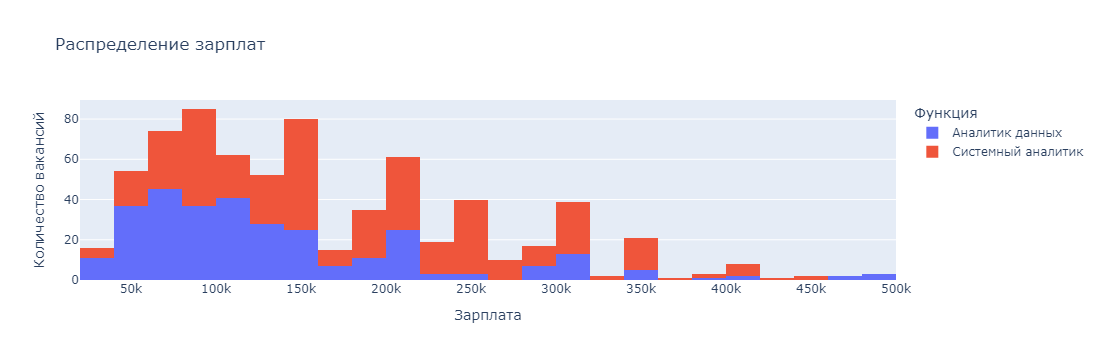

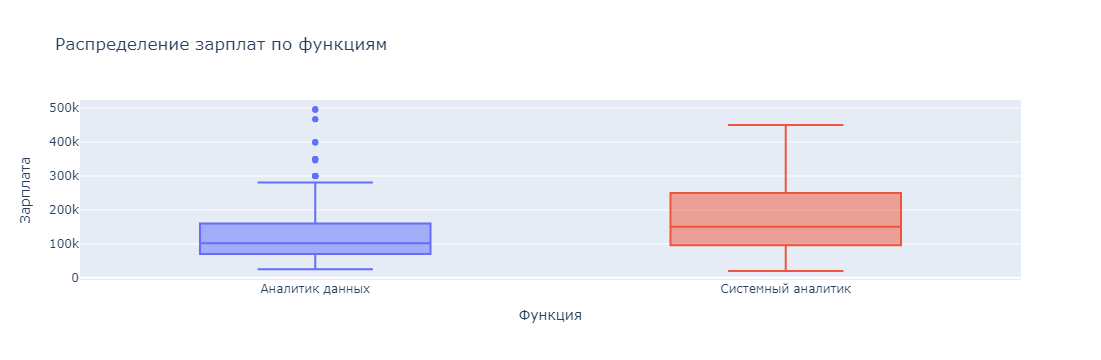

In [44]:
vacancies_with_salary = vacancies_norm.dropna(subset=['salary_from', 'salary_to'])
salary_data = vacancies_with_salary.melt(
    id_vars=['function'],
    value_vars=['salary_from', 'salary_to'],
    var_name='Зарплатный диапазон',
    value_name='Зарплата'
)

# распределения зарплат
fig_hist = px.histogram(
    salary_data,
    x='Зарплата',
    color='function',
    title='Распределение зарплат',
    labels={'Зарплата': 'Зарплата', 'function': 'Функция'},
    nbins=30  # количество корзин
)
fig_hist.update_layout(
    xaxis_title='Зарплата',
    yaxis_title='Количество вакансий',
    showlegend=True
)
fig_hist.show()

fig_box = px.box(
    salary_data,
    x='function',
    y='Зарплата',
    color='function',
    title='Распределение зарплат по функциям',
    labels={'Зарплата': 'Зарплата', 'function': 'Функция'}
)
fig_box.update_layout(
    xaxis_title='Функция',
    yaxis_title='Зарплата',
    showlegend=False
)
fig_box.show()

Большинство зарплат рапределено между 50к и 150к. Есть всплески на 200к и 300к, видимо из-за круглым чисел. Также замечно, что сеньоры аналитики данных, что-то от нас скрывали: вакансии выше 400к представлены значительно реже, что связано с высокой специализацией или редкостью таких позиций - будем к ним стремиться. Мне нравятся эти выбросы выше уса - 😊

Графики популярности ключевых навыков.

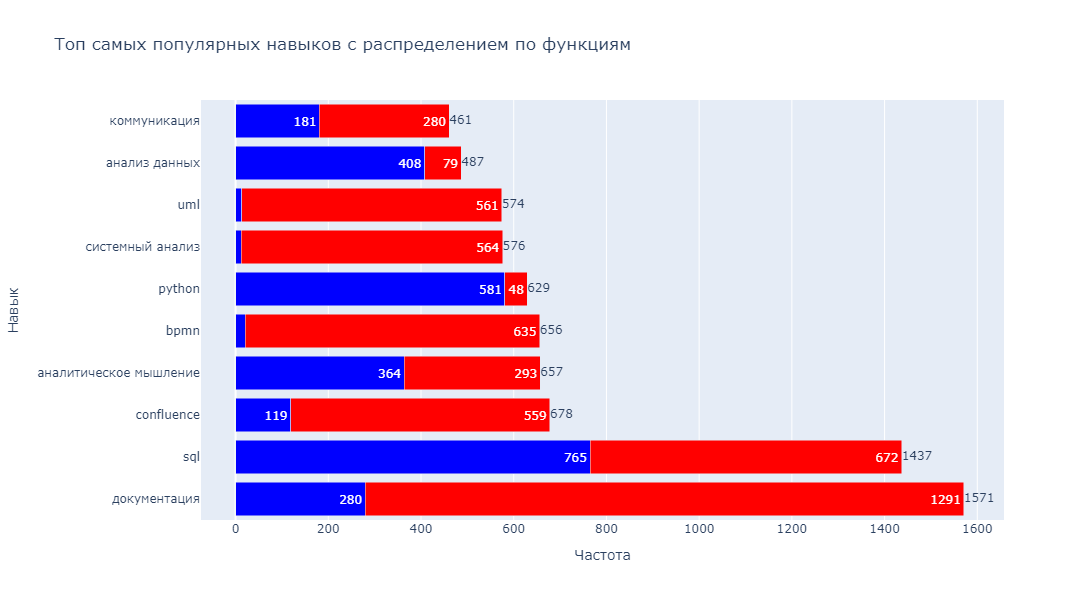

In [47]:
# минус строки с пропусками
vacancies_with_skills = vacancies_norm.dropna(subset=['key_skills'])

# статистика по всем навыкам
all_skills = [skill for skills in vacancies_with_skills['key_skills'] for skill in skills]
skill_counter = Counter(all_skills)
top_skills = skill_counter.most_common(10)  # топ самых популярных навыков
top_skills_df = pd.DataFrame(top_skills, columns=['Навык', 'Частота'])
# распределение навыков по функциям
skill_function_counts = []
for skill in top_skills_df['Навык']:
    counts = vacancies_with_skills[vacancies_with_skills['key_skills'].apply(lambda x: skill in x)].groupby('function').size()
    skill_function_counts.append({
        'Навык': skill,
        'Аналитик данных': counts.get('Аналитик данных', 0),
        'Системный аналитик': counts.get('Системный аналитик', 0)
    })
skill_distribution_df = pd.DataFrame(skill_function_counts)
skill_distribution_df['Частота'] = skill_distribution_df['Аналитик данных'] + skill_distribution_df['Системный аналитик']

fig = go.Figure()
for _, row in skill_distribution_df.iterrows():
    total = row['Частота']
    ad_value = row['Аналитик данных']
    sa_value = row['Системный аналитик']

    # столбик для АД
    fig.add_trace(go.Bar(
        x=[ad_value],
        y=[row['Навык']],
        name='Аналитик данных',
        orientation='h',
        marker=dict(color='blue'),
        text=ad_value,  # частота для АД
        hoverinfo='text',  # только текст
    ))
    # столбик для СА
    fig.add_trace(go.Bar(
        x=[sa_value],
        y=[row['Навык']],
        name='Системный аналитик',
        orientation='h',
        marker=dict(color='red'),
        text=sa_value,  # частота для СА
        hoverinfo='text',  # только текст
        base=ad_value  # начало столбца
    ))
    # добавляем текст с общей суммой справа от столбца
    fig.add_trace(go.Scatter(
        x=[total],
        y=[row['Навык']],
        mode='text',
        text=[total],
        textposition='middle right',
        showlegend=False
    ))
fig.update_layout(
    title='Топ самых популярных навыков с распределением по функциям',
    barmode='stack',
    xaxis_title='Частота',
    yaxis_title='Навык',
    height=600,
    showlegend=False
)
fig.show()

Самое важное в аналитике - Документация (включая Confluence - та же документация) - в 2249 вакансиях, SQL - в 1437 вакансиях и аналитическое мышление - в 657 вакансиях.

Теперь рассмотрим разделение вакансий по городам, графику работы и типам занятости.

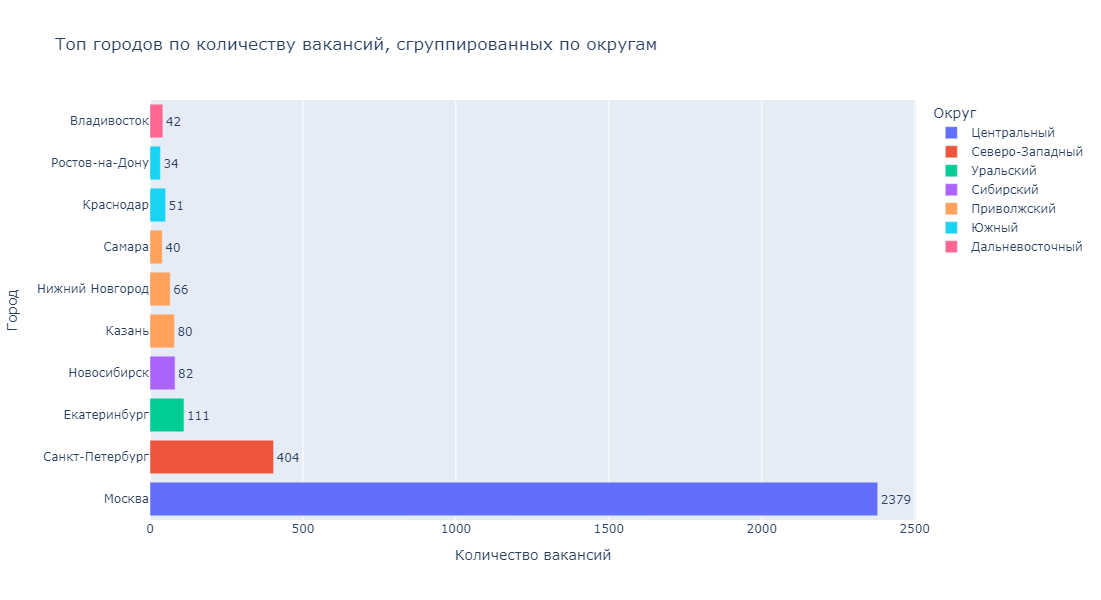

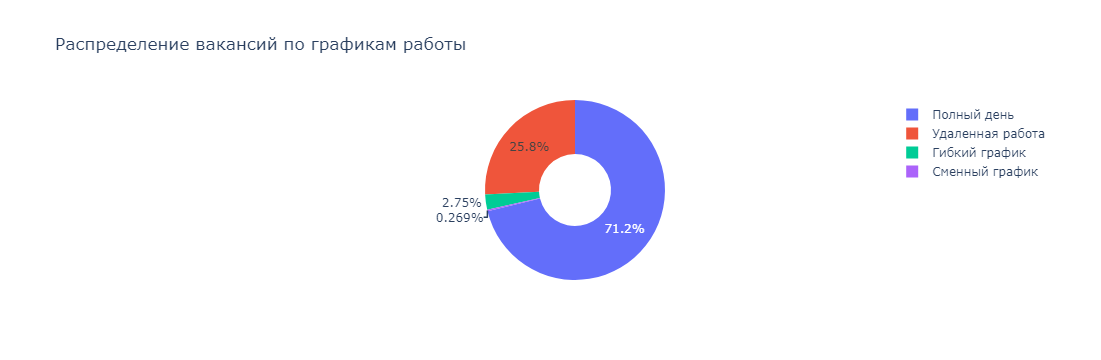

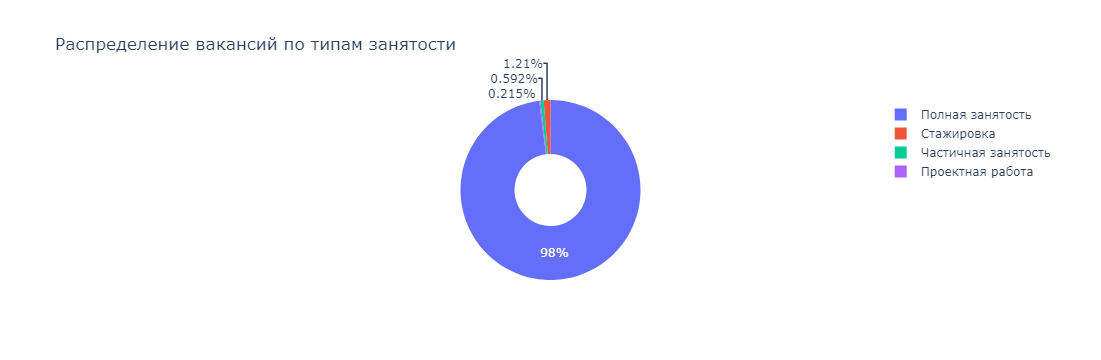

In [50]:
# 1. по топ городам, сгруппированный округам
city_counts = vacancies_norm.groupby(['region', 'district', 'city']).size().reset_index(name='Количество вакансий')
top_cities = city_counts.sort_values(by='Количество вакансий', ascending=False).head(10)
fig_cities = px.bar(
    top_cities,
    x='Количество вакансий',
    y='city',
    color='district',
    text='Количество вакансий',
    orientation='h',
    title='Топ городов по количеству вакансий, сгруппированных по округам',
    labels={'city': 'Город', 'Количество вакансий': 'Количество вакансий', 'district': 'Округ'},
    height=600
)
fig_cities.update_traces(textposition='outside')
fig_cities.update_layout(showlegend=True)
fig_cities.show()

# 2. графики работы в виде бубло-пирога
schedule_counts = vacancies_norm['schedule'].value_counts().reset_index()
schedule_counts.columns = ['График работы', 'Количество вакансий']
fig_schedule = px.pie(
    schedule_counts,
    names='График работы',
    values='Количество вакансий',
    title='Распределение вакансий по графикам работы',
    hole=0.4
)
fig_schedule.show()

# 3. типы занятости в виде бублико-пирога
employment_counts = vacancies_norm['employment'].value_counts().reset_index()
employment_counts.columns = ['Тип занятости', 'Количество вакансий']
fig_employment = px.pie(
    employment_counts,
    names='Тип занятости',
    values='Количество вакансий',
    title='Распределение вакансий по типам занятости',
    hole=0.4
)
fig_employment.show()

Ожидаемо что большинство вакансий в крпуных городах, при этом Москва начительно опережает приследователей - 2379 вакансий, за ней идут Санкт-Петербург - 404 вакансии и Екатиринбург - 111 вакансий. Соответсвенно большинство вакансий из Центрального, Северо-Западного и Уральского округов. 

Предлажение вакансий с полным рабочим днём значительно опережает другие - 71%, за ним идут удалённая работа - 26% и гибкий график - 3%. При этом почти все вакансии с полной занятостью - 98%, остальные имеют незначительный процент.

Т.о. компании нуждются в аналитиках в основном в мегаполисах на полный день и полную занятость.

#### Выводы:
Центральный округ является лидером по числу вакансий, что объясняется доминирующим положением Москвы.
Северо-Западный округ занимает 2е место за счёт высокого количества вакансий в Санкт-Петербурге.
Значительная доля вакансий также приходится на Приволжский и Уральский округа.

### 4. Анализ различий
Цель: Найти ключевые различия между двумя типами вакансий.

Вернёмся к отложенному, но интересному вопросу м зарплатами аналитиков в разрезе опыта.

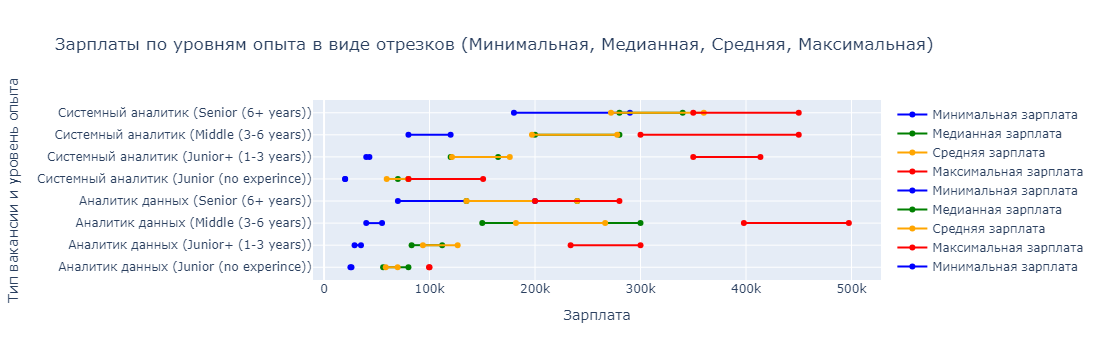

In [55]:
# группировка по функциям и уровням опыта
salary_by_experience = vacancies_with_salary.groupby(['function', 'experience'])[['salary_from', 'salary_to']].agg(['min', 'median', 'mean', 'max'])
salary_by_experience.columns = ['_'.join(col) for col in salary_by_experience.columns]
salary_by_experience.rename(columns={
    'salary_from_min': 'Минимальная зарплата (от)',
    'salary_from_median': 'Медианная зарплата (от)',
    'salary_from_mean': 'Средняя зарплата (от)',
    'salary_from_max': 'Максимальная зарплата (от)',
    'salary_to_min': 'Минимальная зарплата (до)',
    'salary_to_median': 'Медианная зарплата (до)',
    'salary_to_mean': 'Средняя зарплата (до)',
    'salary_to_max': 'Максимальная зарплата (до)',
}, inplace=True)
salary_by_experience = salary_by_experience.reset_index()

fig = go.Figure()
for _, row in salary_by_experience.iterrows():
    # мин. зп
    fig.add_trace(go.Scatter(
        x=[row['Минимальная зарплата (от)'], row['Минимальная зарплата (до)']],
        y=[f"{row['function']} ({row['experience']})", f"{row['function']} ({row['experience']})"],
        mode='lines+markers',
        name='Минимальная зарплата',
        line=dict(color='blue', width=2)
    ))
    # мед. зп
    fig.add_trace(go.Scatter(
        x=[row['Медианная зарплата (от)'], row['Медианная зарплата (до)']],
        y=[f"{row['function']} ({row['experience']})", f"{row['function']} ({row['experience']})"],
        mode='lines+markers',
        name='Медианная зарплата',
        line=dict(color='green', width=2)
    ))
    # ср. зп
    fig.add_trace(go.Scatter(
        x=[row['Средняя зарплата (от)'], row['Средняя зарплата (до)']],
        y=[f"{row['function']} ({row['experience']})", f"{row['function']} ({row['experience']})"],
        mode='lines+markers',
        name='Средняя зарплата',
        line=dict(color='orange', width=2)
    ))
    # макс зп
    fig.add_trace(go.Scatter(
        x=[row['Максимальная зарплата (от)'], row['Максимальная зарплата (до)']],
        y=[f"{row['function']} ({row['experience']})", f"{row['function']} ({row['experience']})"],
        mode='lines+markers',
        name='Максимальная зарплата',
        line=dict(color='red', width=2)
    ))
fig.update_layout(
    title='Зарплаты по уровням опыта в виде отрезков (Минимальная, Медианная, Средняя, Максимальная)',
    xaxis_title='Зарплата',
    yaxis_title='Тип вакансии и уровень опыта',
    showlegend=True
)
fig.show()

Средние ЗП аналитиков без опыта примерно одинаковые. Далее средние ЗП системных аналитиков уверено растут с ростом опыта. Но у аналитиков данных рост наблюдается только до ведущих специалистов. ЗП же главных аналитиков падает до уровня между молодыми специалистами с опытом и ведущими. Скорее всего имеет место коммерческая тайна и высокие ЗП сеньорам и мидлам озвучиваются только после собеседования, в итоге мы видим только заполненне ЗП ниже рынка либо в данные прокралась ошибка 😊

#### Сравним ключевые навыки:

Пострмть список часто встречающихся навыков для каждой роли.

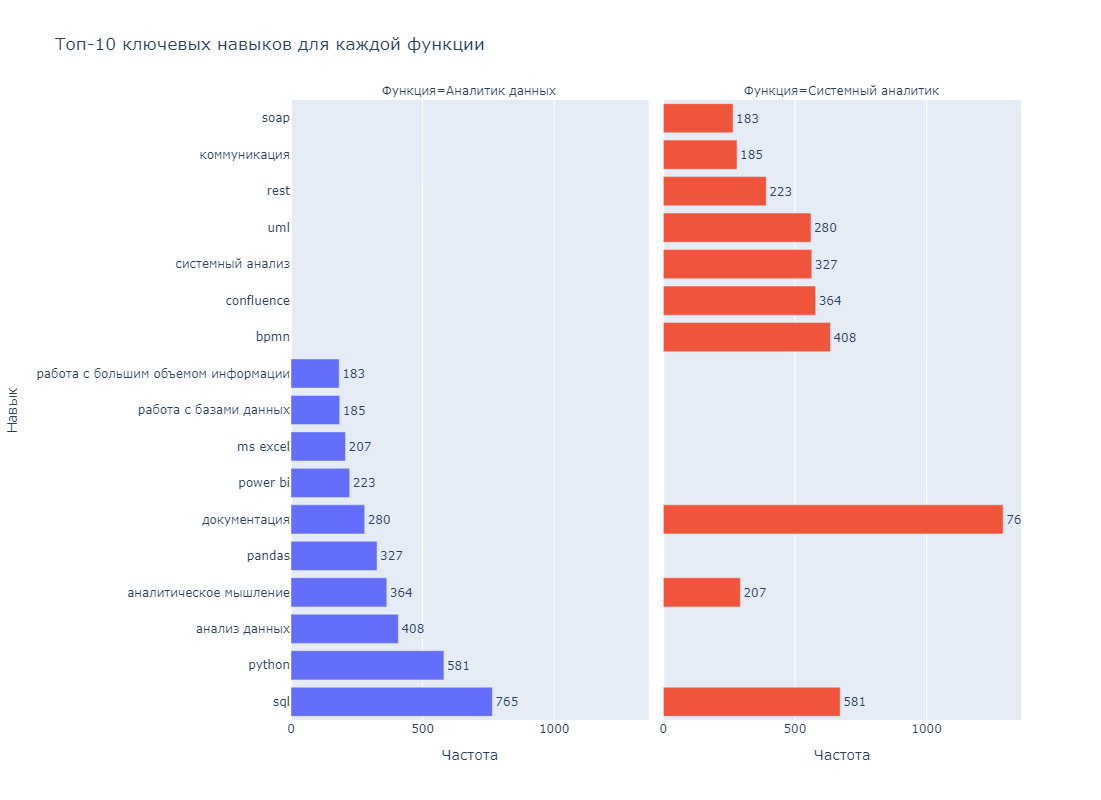

In [58]:
# вакансии с ключевыми навыками
vacancies_with_skills = vacancies_norm.dropna(subset=['key_skills'])
# собираем статистику ключевых навыков для каждой роли
func_skills = []
for func in vacancies_with_skills['function'].unique():
    # данные по ф-ии
    func_data = vacancies_with_skills[vacancies_with_skills['function'] == func]
    # навыки для данной ф-ии
    all_skills = [skill for skills in func_data['key_skills'] for skill in skills]
    # частота навыков
    skill_counter = Counter(all_skills)
    top_skills = skill_counter.most_common(10)  # топ-10 навыков для каждой роли
    for skill, count in top_skills:
        func_skills.append({'Функция': func, 'Навык': skill, 'Частота': count})

# создаем DataFrame с результатами
func_skills_df = pd.DataFrame(func_skills)

# визуализация
fig = px.bar(
    func_skills_df,
    x='Частота',
    y='Навык',
    color='Функция',
    orientation='h',
    title='Топ-10 ключевых навыков для каждой функции',
    facet_col='Функция',
    labels={'Частота': 'Частота', 'Навык': 'Навык', 'Функция': 'Функция'},
    height=800
)
fig.update_traces(text=func_skills_df['Частота'], textposition='outside')
fig.update_layout(showlegend=False)
fig.show()

Самые требуемы навыки аналитиков данных вполне ожидаемы - SQL - 765 вакансий, Python - 581 , анализ данных - 408 упоминаний. У системных аналитиков тоже всё предсказуемо - документация - 1291 вакансия, тот же SQL - 672 вакансии, BPMN (описания бизнес-процессов) - 635 вакансий. Наиболее не пересекающиеся навыки: Python - не нужен системным аналитикам, в то время как аналитики данных смежная функция между системным и бизнес анализом и разработкой; Документация - это вся жизнь системных аналитиков, и слишком скучно для разраб аналитиков данных. 😊

In [60]:
# подсчет навыков по каждой ф-ии
def get_skills_by_func(vacancies_with_skills, func):
    func_data = vacancies_with_skills[vacancies_with_skills['function'] == func]
    all_skills = [skill for skills in func_data['key_skills'] for skill in skills]
    return Counter(all_skills)

func1 = 'Аналитик данных'
func2 = 'Системный аналитик'
# частоты навыков для каждой ф-ии
skills_func1_counter = get_skills_by_func(vacancies_with_skills, func1)
skills_func2_counter = get_skills_by_func(vacancies_with_skills, func2)

# пересечения и уникальные навыки
intersection_skills = (
    pd.DataFrame.from_dict(
        {skill: min(skills_func1_counter[skill], skills_func2_counter[skill]) 
         for skill in skills_func1_counter.keys() & skills_func2_counter.keys()},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': 'Общие навыки'})
)

unique_skills_func1 = (
    pd.DataFrame.from_dict(
        {skill: freq for skill, freq in skills_func1_counter.items() if skill not in skills_func2_counter},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': f'Уникальные навыки ({func1})'})
)

unique_skills_func2 = (
    pd.DataFrame.from_dict(
        {skill: freq for skill, freq in skills_func2_counter.items() if skill not in skills_func1_counter},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': f'Уникальные навыки ({func2})'})
)

comparison_df = pd.concat([intersection_skills, unique_skills_func1, unique_skills_func2], axis=1)
display(comparison_df)

Общие навыки  Частота Уникальные навыки (Аналитик данных)  \
0                     sql      672               статистический анализ   
1  аналитическое мышление      293                           a/b тесты   
2            документация      280                               numpy   
3            коммуникация      181                         power query   
4              confluence      119                 визуализация данных   
5               аналитика       89                        data science   
6              postgresql       88                маркетинговый анализ   
7                  ms sql       88                            superset   
8             базы данных       87                    google analytics   
9  работа с базами данных       82        математическое моделирование   

   Частота Уникальные навыки (Системный аналитик)  Частота  
0       72                               rest api       87  
1       60                   системная интеграция       69  
2       30                                    xsd       56  
3       28                               rabbitmq       46  
4       27               agile project management       44  
5       18                        system analysis       33  
6       18                           apache kafka       32  
7       16                 проектная документация       31  
8       16                             user story       28  
9       15                          разработка по       27

Общие навыки ожидаемы - SQL (включая диалекты различных БД), анлитическое мышление и документация (куда ж без неё).

Уникальные навыки аналитиков данных - статистический анализ, сравнительные тесты, математические библиотеки Python.

Уникальные навыки системных аналитиков - работа с API, системная интеграция, схемы описаний обменных форматов.

#### Сравним зарплаты:

Выявим различия в среднем уровне зарплат.

Функция  Средняя зарплата  Медианная зарплата
0     Аналитик данных          132596.0            105000.0
1  Системный аналитик          177369.0            168750.0

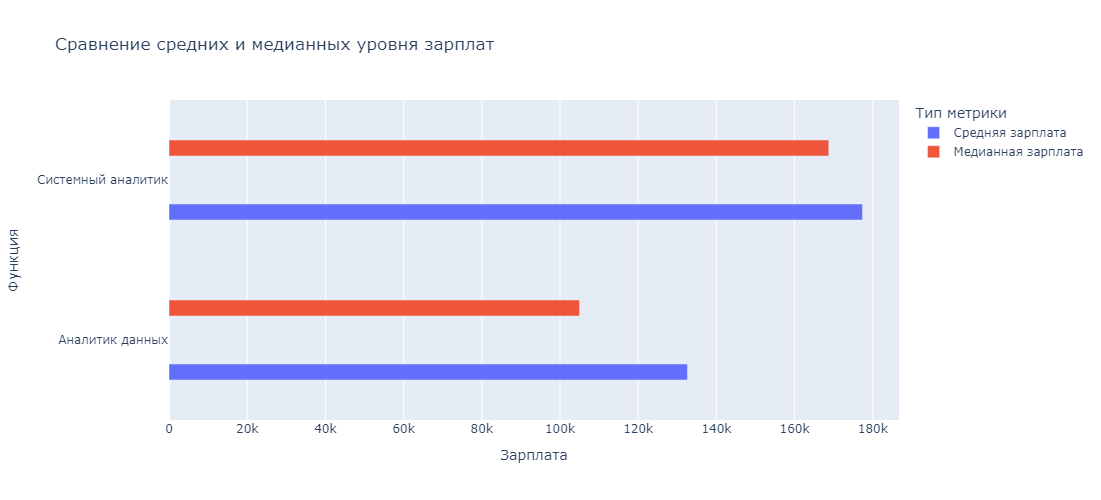

In [64]:
# ср. зп для каждой вакансии
vacancies_norm['Средняя зарплата'] = (vacancies_norm['salary_from'] + vacancies_norm['salary_to']) / 2
# группируем по ф-иям и вычисляем средние и медианные зарплаты
salary_comparison = vacancies_norm.groupby('function').agg(
    {'Средняя зарплата': ['mean', 'median']}
).reset_index()

# переименовываем столбцы для удобства
salary_comparison.columns = ['Функция', 'Средняя зарплата', 'Медианная зарплата']
# округляем до целых
salary_comparison['Средняя зарплата'] = salary_comparison['Средняя зарплата'].round(0)
salary_comparison['Медианная зарплата'] = salary_comparison['Медианная зарплата'].round(0)

# отображаем результаты
display(salary_comparison)

# визуализация различий в средних и медианных зарплатах
fig = px.bar(
    salary_comparison.melt(id_vars='Функция', var_name='Метрика', value_name='Значение'),
    x='Значение',
    y='Функция',
    color='Метрика',
    orientation='h',
    title='Сравнение средних и медианных уровня зарплат',
    labels={'Значение': 'Зарплата', 'Функция': 'Функция', 'Метрика': 'Тип метрики'},
    height=500
)
# настройка ширины столбиков
fig.update_traces(width=0.1)  # задаем толщину столбцов
fig.update_layout(barmode='group', showlegend=True)
fig.show()


Печально, но анлитики днных отстают от системых, грустно 😢

#### Сравним описания вакансий:


Надём различия в терминах и упоминаниях в описании.

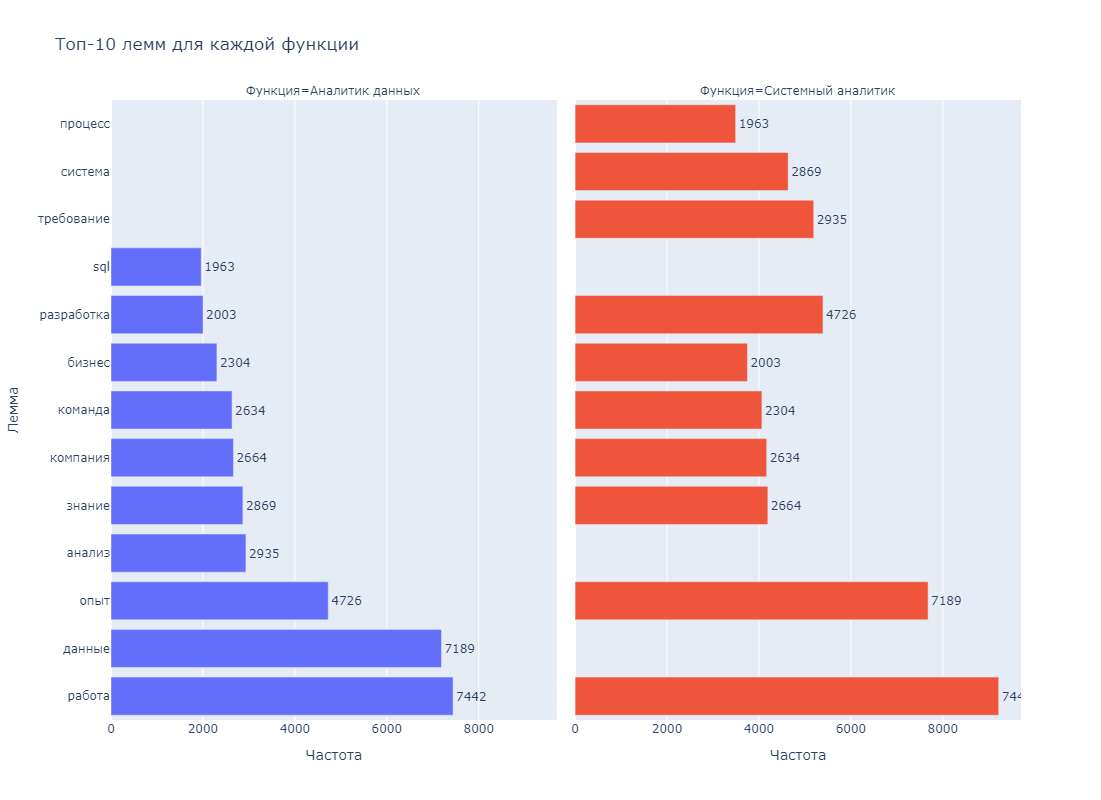

In [68]:
# вакансии с лемматизированными описаниями
vacancies_with_lemmas = vacancies_norm.dropna(subset=['description_lemmatized'])
# преобразуем в списки
def tokenize_lemmas(text):
    if isinstance(text, str):
        return text.split()
    return []

vacancies_with_lemmas['description_lemmatized'] = vacancies_with_lemmas['description_lemmatized'].apply(tokenize_lemmas)
# собираем статистику лемм для каждой ф-ии
func_lemmas = []
for func in vacancies_with_lemmas['function'].unique():
    # фильтруем данные по ф-ии
    func_data = vacancies_with_lemmas[vacancies_with_lemmas['function'] == func]
    # собираем все леммы для данной ф-ии
    all_lemmas = [lemma for lemmas in func_data['description_lemmatized'] for lemma in lemmas if len(lemma) > 1]
    # подсчитываем частоту лемм
    lemma_counter = Counter(all_lemmas)
    top_lemmas = lemma_counter.most_common(10)  # топ лемм для каждой роли
    for lemma, count in top_lemmas:
        func_lemmas.append({'Функция': func, 'Лемма': lemma, 'Частота': count})
func_lemmas_df = pd.DataFrame(func_lemmas)

fig = px.bar(
    func_lemmas_df,
    x='Частота',
    y='Лемма',
    color='Функция',
    orientation='h',
    title='Топ-10 лемм для каждой функции',
    facet_col='Функция',
    labels={'Частота': 'Частота', 'Лемма': 'Лемма', 'Функция': 'Функция'},
    height=800
)
fig.update_traces(text=func_lemmas_df['Частота'], textposition='outside')
fig.update_layout(showlegend=False)
fig.show()

Наиболее частые леммы в описаних вакансий аналитиков данных - работа, данные и опыт, у системных аналитиков - работа, опыт, рзработка.

In [70]:
# подсчет лемм по каждой ф-ии
def get_lemmas_by_func(vacancies_with_lemmas, func):
    func_data = vacancies_with_lemmas[vacancies_with_lemmas['function'] == func]
    all_lemmas = [lemma for lemmas in func_data['description_lemmatized'] for lemma in lemmas]
    return Counter(all_lemmas)

# ф-ии для сравнения
func1 = 'Аналитик данных'
func2 = 'Системный аналитик'
# частоты лемм для каждой ф-ии
lemmas_func1_counter = get_lemmas_by_func(vacancies_with_lemmas, func1)
lemmas_func2_counter = get_lemmas_by_func(vacancies_with_lemmas, func2)

# находим пересечения и уникальные леммы
intersection_lemmas = (
    pd.DataFrame.from_dict(
        {lemma: min(lemmas_func1_counter[lemma], lemmas_func2_counter[lemma]) 
         for lemma in lemmas_func1_counter.keys() & lemmas_func2_counter.keys()},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': 'Общие леммы'})
)

unique_lemmas_func1 = (
    pd.DataFrame.from_dict(
        {lemma: freq for lemma, freq in lemmas_func1_counter.items() if lemma not in lemmas_func2_counter},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': f'Уникальные леммы ({func1})'})
)

unique_lemmas_func2 = (
    pd.DataFrame.from_dict(
        {lemma: freq for lemma, freq in lemmas_func2_counter.items() if lemma not in lemmas_func1_counter},
        orient='index',
        columns=['Частота']
    )
    .sort_values(by='Частота', ascending=False)
    .head(10)
    .reset_index()
    .rename(columns={'index': f'Уникальные леммы ({func2})'})
)

comparison_df = pd.concat([intersection_lemmas, unique_lemmas_func1, unique_lemmas_func2], axis=1)
display(comparison_df)

Общие леммы  Частота Уникальные леммы (Аналитик данных)  Частота  \
0      работа     7442                                мат       57   
1        опыт     4726                          qliksense       56   
2      знание     2869                          факторный       52   
3    компания     2664                             plotly       49   
4     команда     2634                           metabase       44   
5      бизнес     2304                            воронок       42   
6      анализ     2069                                 da       41   
7  разработка     2003                                аба       40   
8      данные     1890                              learn       39   
9      задача     1838                                 ab       36   

  Уникальные леммы (Системный аналитик)  Частота  
0                               swagger      227  
1                                    mq      159  
2                                  grpc       94  
3                               camunda       88  
4                           асинхронный       73  
5                               ступень       70  
6                                soapui       68  
7                              plantuml       63  
8                          межсистемный       57  
9                            синхронный       56

Общие леммы - работа, опыт, знания - не удивительно.

Уникальные леммы аналитиков данных - математический анализ (я надеюсь, что речь именно про это 😊), визуализация метрик, факторный анализ.

Уникальные леммы системных аналитиков - работа с API, работа с брокерами очередей, удалённый вызов процедур - подозреваю, что всё это нужно для приёмки продуктов.

#### Определим типичные места работы:

Построимь список компаний, которые чаще всего публикуют вакансии.

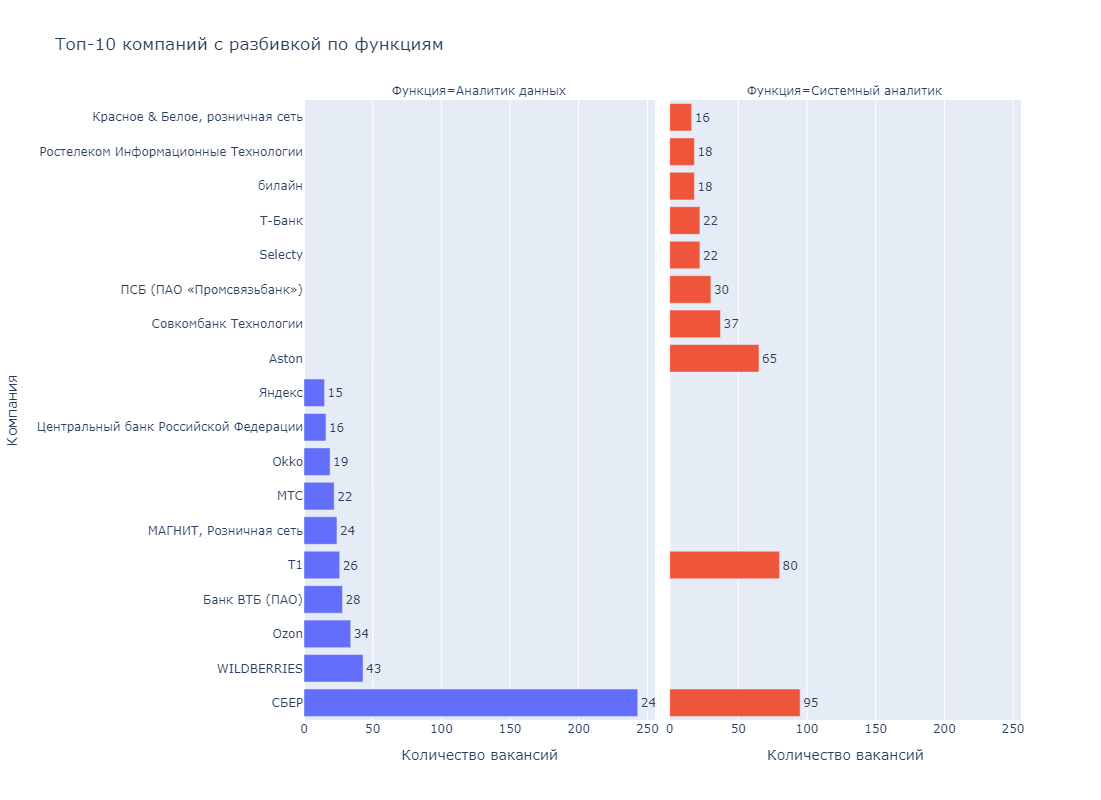

In [74]:
# вакансии с указанием компаний
vacancies_with_companies = vacancies_norm.dropna(subset=['employer'])

# статистика компаний для каждой функции
func_companies = []
for func in vacancies_with_companies['function'].unique():
    # фильтруем данные по функции
    func_data = vacancies_with_companies[vacancies_with_companies['function'] == func]
    # количество вакансий по компаниям
    company_counter = func_data['employer'].value_counts()
    top_companies = company_counter.head(10)  # топ компаний для каждой функции
    for company, count in top_companies.items():
        func_companies.append({'Функция': func, 'Компания': company, 'Количество вакансий': count})
func_companies_df = pd.DataFrame(func_companies)

fig = px.bar(
    func_companies_df,
    x='Количество вакансий',
    y='Компания',
    color='Функция',
    orientation='h',
    title='Топ-10 компаний с разбивкой по функциям',
    facet_col='Функция',
    labels={'Количество вакансий': 'Количество вакансий', 'Компания': 'Компания', 'Функция': 'Функция'},
    height=800
)
fig.for_each_trace(lambda trace: trace.update(
    text=func_companies_df[func_companies_df['Функция'] == trace.name]['Количество вакансий'],
    textposition='outside'
))
fig.update_layout(
    showlegend=False,
    xaxis_title='Количество вакансий',
    yaxis_title='Компания'
)
fig.show()

С большим отрывом по анализу данных лидирует СБЕР (скорее всего маркет-плейсы СберМаркет) - 243 вакансии, сильно отставая далее следуют марект-плейсы WildBerries - 43 вакансии и Ozon - 34 вакансии. В системном анализе лидируют тот же СБЕР (тут скорее всего IT-компания СберТех) - 95 вакансий, IT-компании Т1 и Aston.

Очевидно, что наиболее востребованы анлитики данных у маркет-плейсов, а системные аналитики у IT-компаний.

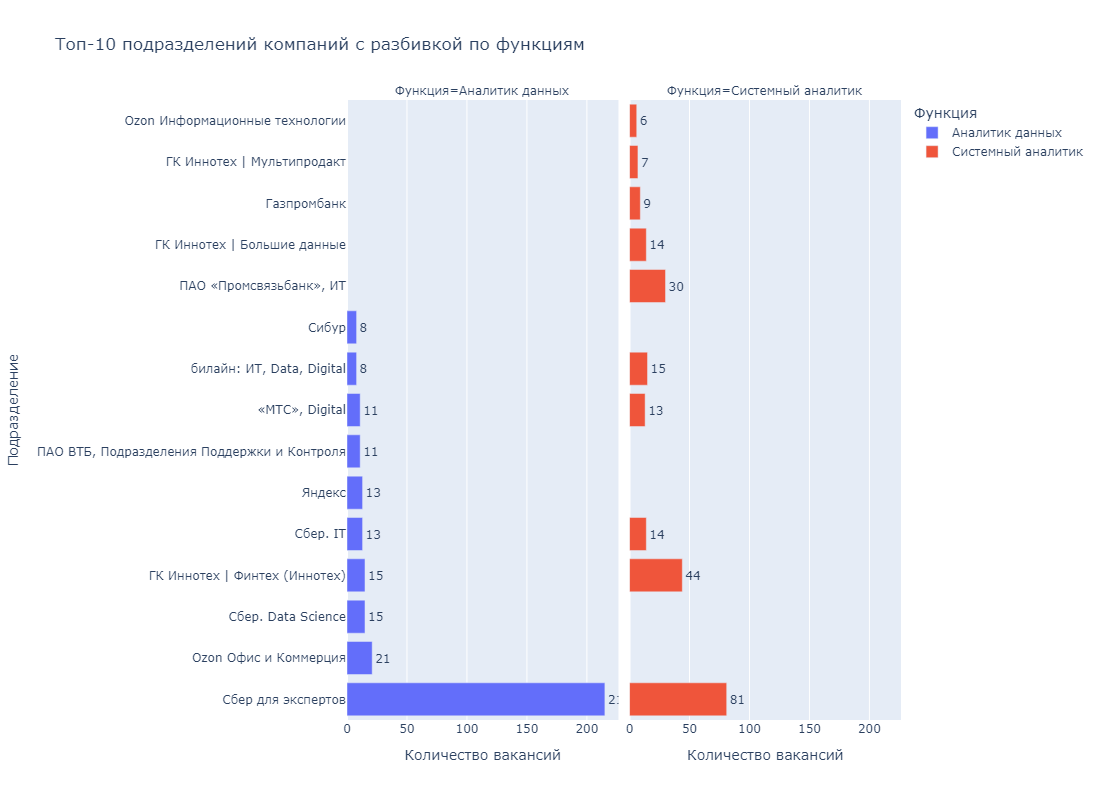

In [76]:
# вакансии с указанием подразделений
vacancies_with_divisions = vacancies_norm.dropna(subset=['department']).copy()  # создаем копию DataFrame
vacancies_with_divisions['Подразделение'] = vacancies_with_divisions['department'].fillna(vacancies_with_divisions['employer'])

# статистика подразделений для каждой функции
func_divisions = []
for func in vacancies_with_divisions['function'].unique():
    # фильтруем данные по функции
    func_data = vacancies_with_divisions[vacancies_with_divisions['function'] == func]
    # количество вакансий по подразделениям
    division_counter = func_data['Подразделение'].value_counts()
    top_divisions = division_counter.head(10)  # топ подразделений для каждой функции
    for division, count in top_divisions.items():
        func_divisions.append({'Функция': func, 'Подразделение': division, 'Количество вакансий': count})
func_divisions_df = pd.DataFrame(func_divisions)

fig = px.bar(
    func_divisions_df,
    x='Количество вакансий',
    y='Подразделение',
    color='Функция',
    orientation='h',
    title='Топ-10 подразделений компаний с разбивкой по функциям',
    facet_col='Функция',
    labels={'Количество вакансий': 'Количество вакансий', 'Подразделение': 'Подразделение', 'Функция': 'Функция'},
    height=800
)

fig.for_each_trace(lambda trace: trace.update(
    text=func_divisions_df[func_divisions_df['Функция'] == trace.name]['Количество вакансий'],
    textposition='outside'
))
fig.update_layout(
    showlegend=True,
    xaxis_title='Количество вакансий',
    yaxis_title='Подразделение'
)
fig.show()

Если взглянуть на вакансии в разрезе обособленных подразделений, то для аналитиков данных с большим отрывом будет также СБЕР (Сбер для экпертов - подразделение, управляющее небанковскими проектами, в т.ч. маркет-плейсом) - 215 вакансий, далее со значительтным отрывам следуют Ozon Офис и Коммерция (всё тот же маркет-плейс) - 21 вакансия, а также Сбер Data Science (отдельное продразделение для разработок в области ИИ). У системных аналитиков лидируют опять Сбер для экспертов (в том числе и включающий разработку ПО) - 81 вакансия, разработчик ПО ГК ИнноТех | ФинТех (ИнноТех) - 44 вакансии и ИТ подразделение ПАО ПромСвязьБанка - 30 вакансии.

В итоге частично подтверждаются высокая потребность в аналитиках данных у маркет-плейсов и системных аналитиков у разработчикв ПО.

#### Выявим распределение по регионам:

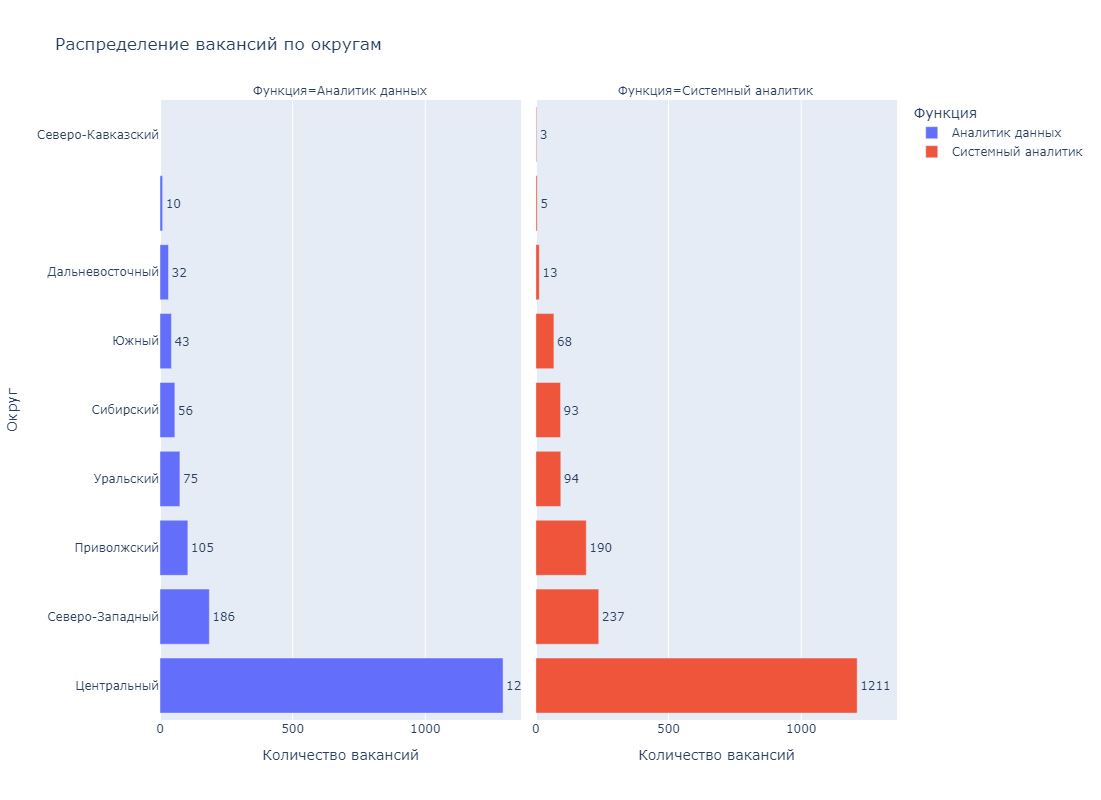

In [79]:
# убираем строки с пропусками в колонке с округами
vacancies_with_districts = vacancies_norm.dropna(subset=['district'])
# статистика округов для каждой функции
func_districts = []
for func in vacancies_with_districts['function'].unique():
    # фильтруем данные по функции
    func_data = vacancies_with_districts[vacancies_with_districts['function'] == func]
    # количество вакансий по округам
    district_counter = func_data['district'].value_counts()
    top_districts = district_counter.head(10)  # топ-10 округов для каждой функции
    for district, count in top_districts.items():
        func_districts.append({'Функция': func, 'Округ': district, 'Количество вакансий': count})
func_districts_df = pd.DataFrame(func_districts)

fig = px.bar(
    func_districts_df,
    x='Количество вакансий',
    y='Округ',
    color='Функция',
    orientation='h',
    title='Распределение вакансий по округам',
    facet_col='Функция',
    labels={'Количество вакансий': 'Количество вакансий', 'Округ': 'Округ', 'Функция': 'Функция'},
    height=800
)
# добавляем текстовые метки для каждого столбика
fig.for_each_trace(lambda trace: trace.update(
    text=func_districts_df[func_districts_df['Функция'] == trace.name]['Количество вакансий'],
    textposition='outside'
))
# обновляем настройки
fig.update_layout(
    showlegend=True,
    xaxis_title='Количество вакансий',
    yaxis_title='Округ'
)
fig.show()

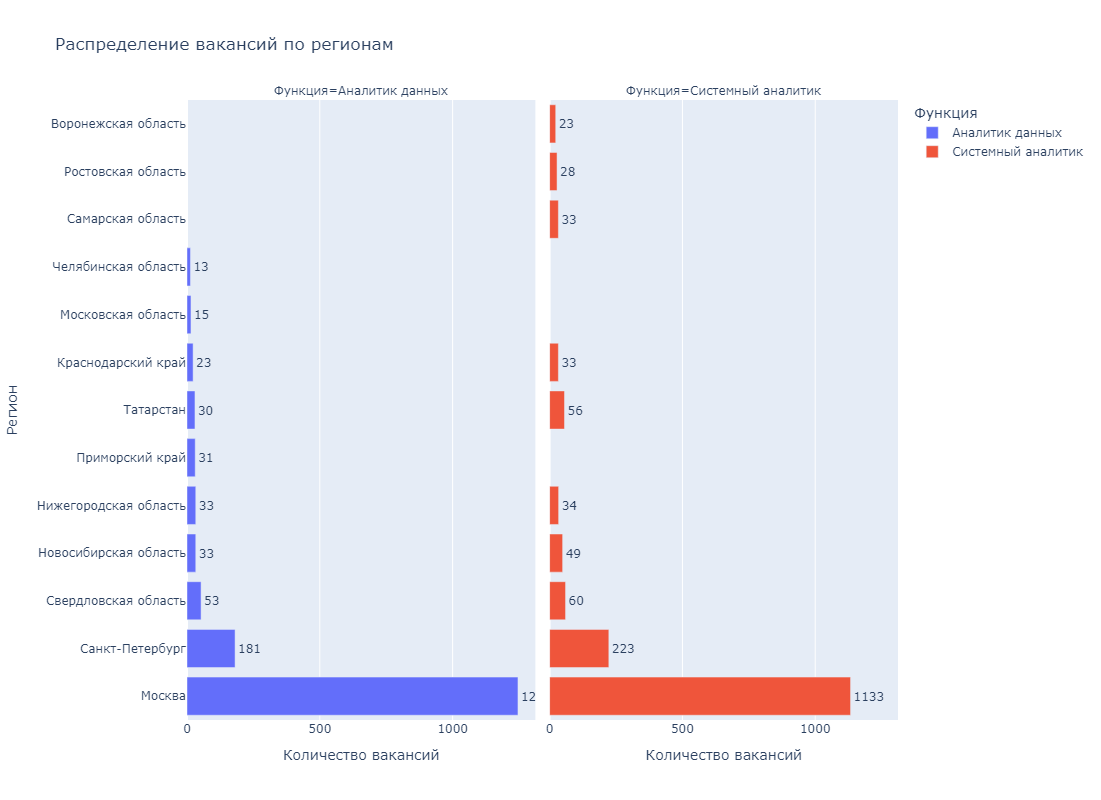

In [80]:
# убираем строки с пропусками в колонке с регионами
vacancies_with_regions = vacancies_norm.dropna(subset=['region'])
# статистика регионов для каждой функции
func_regions = []
for func in vacancies_with_regions['function'].unique():
    # фильтруем данные по функции
    func_data = vacancies_with_regions[vacancies_with_regions['function'] == func]
    # количество вакансий по регионам
    region_counter = func_data['region'].value_counts()
    top_regions = region_counter.head(10)  # топ-10 регионов для каждой функции
    for region, count in top_regions.items():
        func_regions.append({'Функция': func, 'Регион': region, 'Количество вакансий': count})
func_regions_df = pd.DataFrame(func_regions)

fig = px.bar(
    func_regions_df,
    x='Количество вакансий',
    y='Регион',
    color='Функция',
    orientation='h',
    title='Распределение вакансий по регионам',
    facet_col='Функция',
    labels={'Количество вакансий': 'Количество вакансий', 'Регион': 'Регион', 'Функция': 'Функция'},
    height=800
)
# добавляем текстовые метки для каждого столбика
fig.for_each_trace(lambda trace: trace.update(
    text=func_regions_df[func_regions_df['Функция'] == trace.name]['Количество вакансий'],
    textposition='outside'
))
fig.update_layout(
    showlegend=True,
    xaxis_title='Количество вакансий',
    yaxis_title='Регион'
)
fig.show()

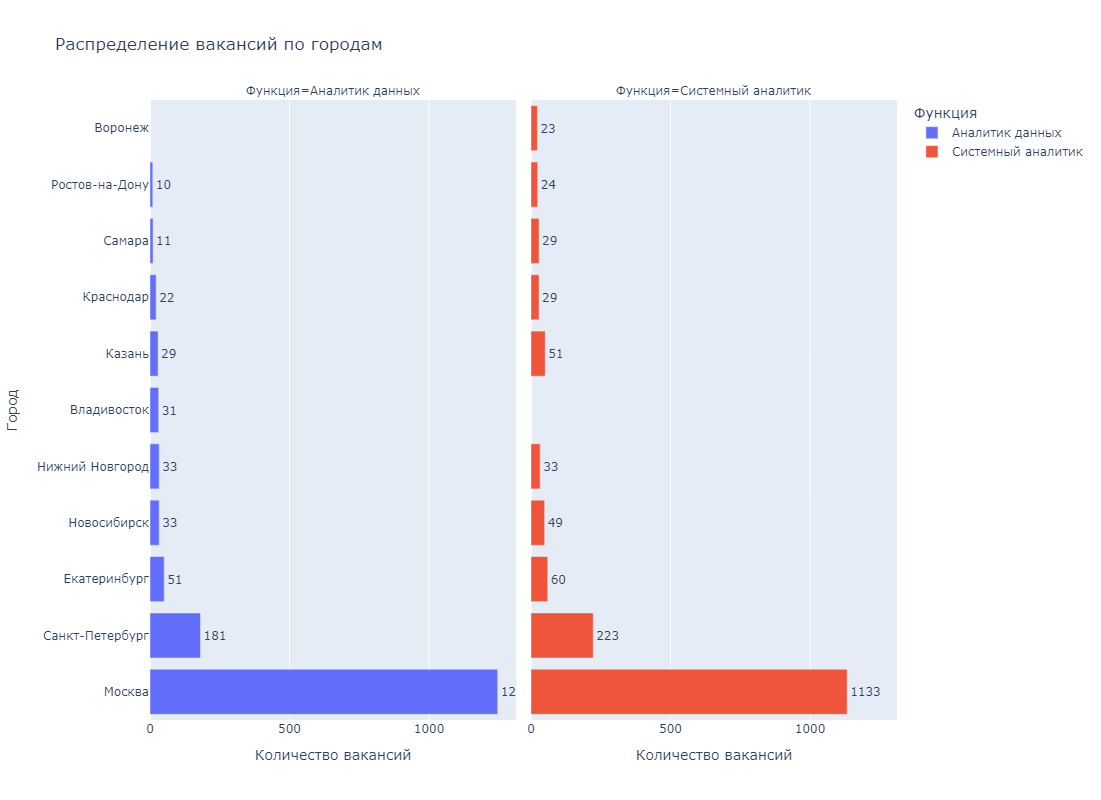

In [81]:
# убираем строки с пропусками в колонке с городами
vacancies_with_cities = vacancies_norm.dropna(subset=['city'])
# статистика городов для каждой функции
func_cities = []
for func in vacancies_with_cities['function'].unique():
    # фильтруем данные по функции
    func_data = vacancies_with_cities[vacancies_with_cities['function'] == func]
    # количество вакансий по городам
    city_counter = func_data['city'].value_counts()
    top_cities = city_counter.head(10)  # топ городов для каждой функции
    for city, count in top_cities.items():
        func_cities.append({'Функция': func, 'Город': city, 'Количество вакансий': count})
func_cities_df = pd.DataFrame(func_cities)

fig = px.bar(
    func_cities_df,
    x='Количество вакансий',
    y='Город',
    color='Функция',
    orientation='h',
    title='Распределение вакансий по городам',
    facet_col='Функция',
    labels={'Количество вакансий': 'Количество вакансий', 'Город': 'Город', 'Функция': 'Функция'},
    height=800
)
# добавляем текстовые метки для каждого столбика
fig.for_each_trace(lambda trace: trace.update(
    text=func_cities_df[func_cities_df['Функция'] == trace.name]['Количество вакансий'],
    textposition='outside'
))
fig.update_layout(
    showlegend=True,
    xaxis_title='Количество вакансий',
    yaxis_title='Город'
)
fig.show()

По графикам видно, что большую часть статитики регионов и округов делают крупные мегаполисы - IT-лидеры. При этом основной вклад обеспечивает Москва - 1246 и 1133 вакансии соответсвенно, далее с заметным отставанием Санкт-Петербург - 181 и 223 вакансии и Екатиринбург - 51 и 60 вакансий. При это какой то значительной разницы между функциями нет, распределение примерно одинковое.

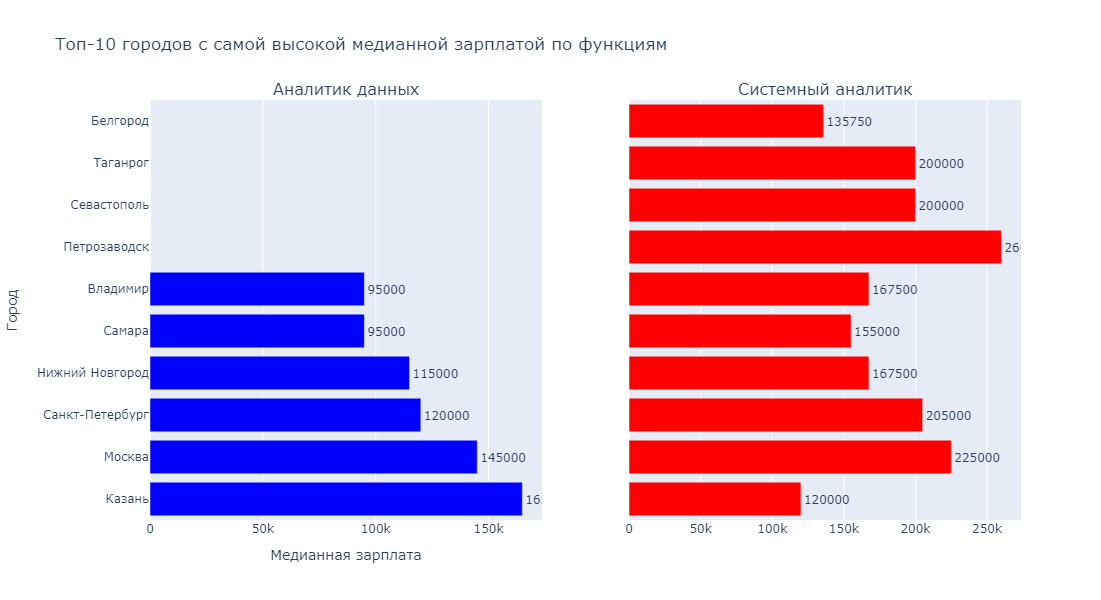

In [83]:
# убираем строки с пропусками
vacancies_with_salaries = vacancies_norm.dropna(subset=['salary_from', 'salary_to', 'city', 'experience']).copy()
vacancies_with_salaries['average_salary'] = (vacancies_with_salaries['salary_from'] + vacancies_with_salaries['salary_to']) / 2

# данные для мед. зп
median_city_salaries = (
    vacancies_with_salaries.groupby('city')['average_salary']
    .median()
    .sort_values(ascending=False)
    .head(10)
)
top_cities = median_city_salaries.index
filtered_vacancies = vacancies_with_salaries[vacancies_with_salaries['city'].isin(top_cities)]

median_salaries = []
for func in filtered_vacancies['function'].unique():
    func_data = filtered_vacancies[filtered_vacancies['function'] == func]
    for city in func_data['city'].unique():
        city_data = func_data[func_data['city'] == city]
        median_salary = city_data['average_salary'].median()
        median_salaries.append({
            'Функция': func,
            'Город': city,
            'Медианная зарплата': median_salary
        })
median_salaries_df = pd.DataFrame(median_salaries)
sorted_median_salaries_df = median_salaries_df.sort_values(by='Медианная зарплата', ascending=False)

fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=['Аналитик данных', 'Системный аналитик'],
    shared_yaxes=True
)

# данные для АД
data_analyst_df = sorted_median_salaries_df[sorted_median_salaries_df['Функция'] == 'Аналитик данных']
fig.add_trace(
    go.Bar(
        x=data_analyst_df['Медианная зарплата'],
        y=data_analyst_df['Город'],
        name='Аналитик данных',
        orientation='h',
        marker_color='blue',
        text=data_analyst_df['Медианная зарплата'],
        textposition='outside'
    ),
    row=1, col=1
)

# данные для СА
system_analyst_df = sorted_median_salaries_df[sorted_median_salaries_df['Функция'] == 'Системный аналитик']
fig.add_trace(
    go.Bar(
        x=system_analyst_df['Медианная зарплата'],
        y=system_analyst_df['Город'],
        name='Системный аналитик',
        orientation='h',
        marker_color='red',
        text=system_analyst_df['Медианная зарплата'],
        textposition='outside'
    ),
    row=1, col=2
)

fig.update_layout(
    title='Топ-10 городов с самой высокой медианной зарплатой по функциям',
    xaxis_title='Медианная зарплата',
    yaxis_title='Город',
    showlegend=False,
    height=600,
    width=1000
)
fig.show()

Высокие зарплаты наблюдатся как в мегаполисах так и в небольших города (например, Таганрог).

#### Выводы:
Зарплаты аналитиков данных и системных аналитиков сильно варьируются в зависимости от региона и уровня квалификации.
Вакансии в Москве и Санкт-Петербурге предлагают на 30-50% более высокие зарплаты по сравнению с регионами.
Системные аналитики имеют чуть более высокий уровень зарплат в среднем по сравнению с аналитиками данных.

### 5. Подготовка визуализаций
Цель: Оформить результаты для понятного представления.

#### Построим графики и диаграммы:

Гистограммы для распределения зарплат.

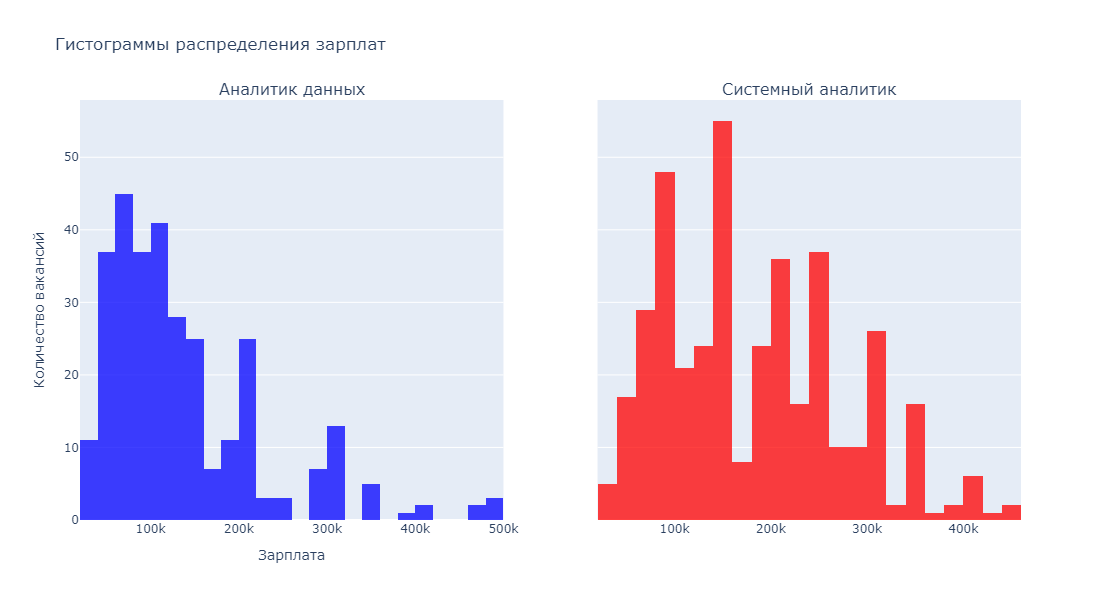

In [89]:
# убираем строки с пропусками в зарплатах
vacancies_with_salaries = vacancies_norm.dropna(subset=['salary_from', 'salary_to'])

# создаём данные для каждой функции
func_salary_data = []
for func in vacancies_with_salaries['function'].unique():
    func_data = vacancies_with_salaries[vacancies_with_salaries['function'] == func]
    salary_data = {
        'function': func,
        'salary': list(func_data['salary_from']) + list(func_data['salary_to'])  # объединяем границы зарплат
    }
    func_salary_data.append(salary_data)

# строим гистограммы
fig = make_subplots(
    rows=1,
    cols=len(func_salary_data),
    subplot_titles=[data['function'] for data in func_salary_data],
    shared_yaxes=True
)

colors = ['blue', 'red']  # цвета для каждой функции
for idx, data in enumerate(func_salary_data):
    fig.add_trace(
        go.Histogram(
            x=data['salary'],
            name=data['function'],
            marker=dict(color=colors[idx % len(colors)]),
            opacity=0.75
        ),
        row=1,
        col=idx + 1
    )

# обновляем настройки графика
fig.update_layout(
    title_text='Гистограммы распределения зарплат',
    xaxis_title='Зарплата',
    yaxis_title='Количество вакансий',
    showlegend=False,
    height=600
)
fig.show()

Пики приходятся на "круглые" зарплаты. Максимальное число вакансий аналитика данных приходится на 60-80 т.р., 3 максимальных зарплаты укладываются в 480-500 т.р. Максимальное число вакансий системного аналитика приходится на 140-160 т.р., 3 максимальных зарплаты укладываются в 420-460 т.р. В итоге - средние зарпалты системных аналитиков выше, чем у аналитиков данных, но максимальные примерно одинаковы.

Word Cloud для частотного анализа навыков и описаний.

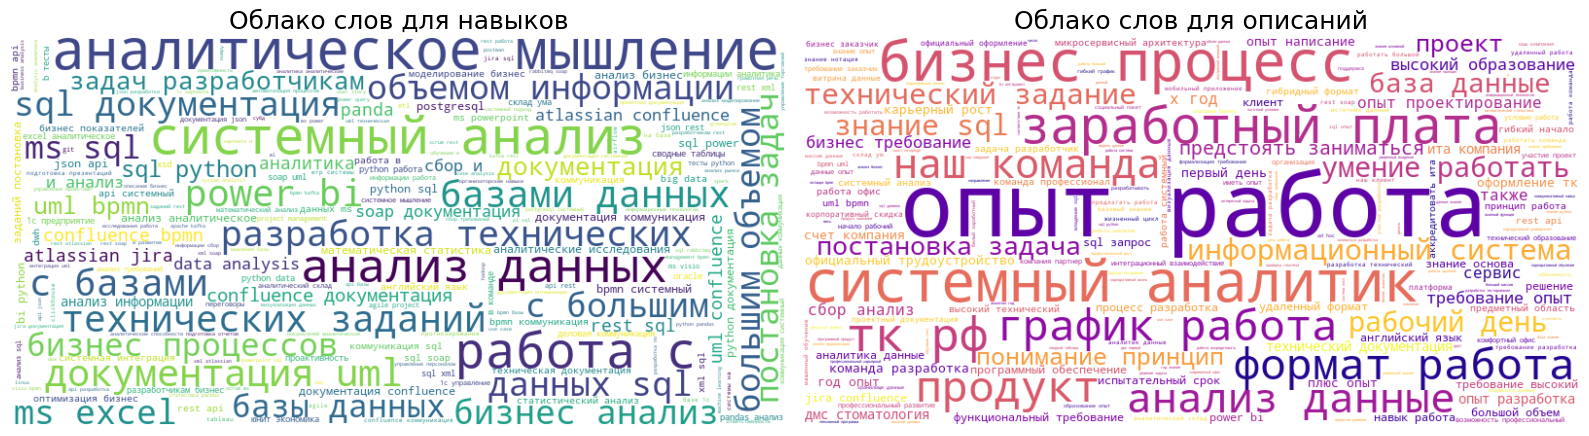

In [92]:
vacancies_with_skills = vacancies_norm.dropna(subset=['key_skills'])
vacancies_with_descriptions = vacancies_norm.dropna(subset=['description_lemmatized'])

# текст для word cloud из навыков
skills_text = ' '.join([' '.join(skills) for skills in vacancies_with_skills['key_skills']])
# текст для word cloud из описаний
descriptions_text = ' '.join([' '.join(desc.split()) for desc in vacancies_with_descriptions['description_lemmatized']])

# создание облака слов для навыков
wordcloud_skills = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200
).generate(skills_text)

# создание облака слов для описаний вакансий
wordcloud_descriptions = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='plasma', 
    max_words=200
).generate(descriptions_text)

plt.figure(figsize=(16, 8))

# Word Cloud для навыков
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_skills, interpolation='bilinear')
plt.title('Облако слов для навыков', fontsize=18)
plt.axis('off')

# Word Cloud для описаний
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_descriptions, interpolation='bilinear')
plt.title('Облако слов для описаний', fontsize=18)
plt.axis('off')

plt.tight_layout()
plt.show()

Получилось красивое! Видно, что среди навыков превалируют анлиз данных, системный анализ и аналитическое мышлешление. Среди описаний опты и работа..

Графики для сравнения числа вакансий и регионального распределения.

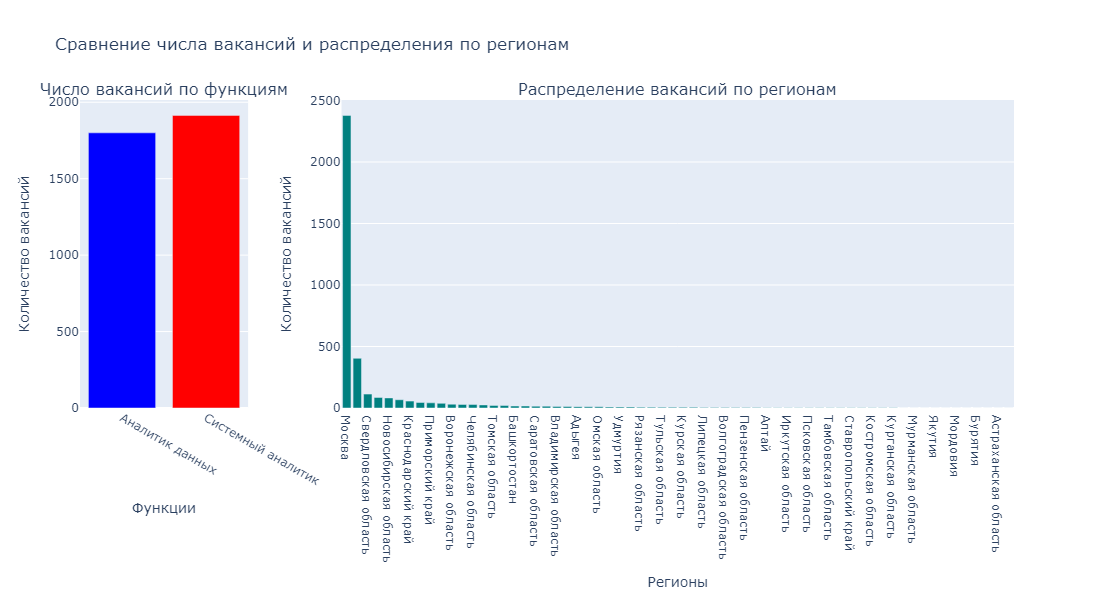

In [95]:
func_vacancies = vacancies_norm['function'].value_counts()
region_vacancies = vacancies_norm['region'].value_counts()
# переупорядочиваем функции, чтобы Аналитик данных был первым
func_vacancies = func_vacancies.reindex(['Аналитик данных', 'Системный аналитик'])

# создаём подграфики
fig = make_subplots(
    rows=1,
    cols=2,
    column_widths=[0.2, 0.8],  # изменяем ширины графиков
    subplot_titles=["Число вакансий по функциям", "Распределение вакансий по регионам"]
)

# график числа вакансий по функциям
fig.add_trace(
    go.Bar(
        x=func_vacancies.index,
        y=func_vacancies.values,
        name="Функции",
        marker_color=['blue', 'red']  # синий для АД, красный для СА
    ),
    row=1, col=1
)

# график распределения вакансий по регионам
fig.add_trace(
    go.Bar(
        x=region_vacancies.index,
        y=region_vacancies.values,
        name="Регионы",
        marker_color='teal'  # один цвет для регионов
    ),
    row=1, col=2
)

fig.update_xaxes(title_text="Функции", row=1, col=1)
fig.update_yaxes(title_text="Количество вакансий", row=1, col=1)

fig.update_xaxes(title_text="Регионы", row=1, col=2)
fig.update_yaxes(title_text="Количество вакансий", row=1, col=2)

fig.update_layout(
    title_text="Сравнение числа вакансий и распределения по регионам",
    showlegend=False,
    height=600,
    width=1200
)
fig.show()

Количество разных функций примерно одинаково, а зато в городах минимум на порядок всех опережает Москва.

#### Выводы:
Ключевые навыки для аналитиков данных: SQL, Python, работа с данными и аналитическое мышление.
Для системных аналитиков чаще встречаются навыки работы с UML, BPMN, и опыт в системном анализе.
В описаниях вакансий часто фигурируют требования к работе в команде, наличие опыта и навыков взаимодействия с другими отделами.

### Ключевые выводы и результаты

#### Итоги по гипотезам:
Гипотеза 1: Системные аналитики имеют более высокие зарплатв среднем, чем аналитики данных.

Гипотеза 2: Любые Аналитики данных больше требуются в регионах с высокой концентрацией IT-компаний.

#### Распределение вакансий по функциям:
Аналитики данных и системные аналитики занимают сопоставимые доли среди вакансий.
Вакансий для аналитиков данных чуть меньше, чем для системных аналитиков.
Ключевая разница: аналитики данных чаще работают с данными, моделями и инструментами анализа, а системные аналитики — с системными процессами, моделированием и проектированием.

#### Распределение по регионам и округам:
Москва и Санкт-Петербург либируют как регионы с наибольшим количеством вакансий.
Центральный округ занимает лидирующую позицию, на 2м месте — Северо-Западный округ.
В регионах с меньшим количеством вакансий (например, в Сибири и на Дальнем Востоке) спрос на специалистов ниже, но компании готовы предлагать удалённые варианты работы.

#### Анализ зарплат:
Зарплаты выше в мегаполисах и регионах, в которых представлены крупные IT-компании.
Системные аналитики получают чуть больше, чем аналитики данных, из-за специфики их навыков.
Средние зарплаты значительно варьируются, в зависимости от опыта, региона и размера компании.

#### Навыки и описания вакансий:
Аналитики данных: SQL, Python, анализ данных и визуализация являются ключевыми навыками.
Системные аналитики: UML, BPMN, системный анализ и документация.
Важными дополнительными навыками для обеих профессий остаются коммуникация и аналитическое мышление.

#### Методы анализа:
Очистка и предобработка данных: Удалены строки с пропусками в ключевых столбцах (зарплаты, регионы, функции, навыки).
Проведена лемматизация для анализа текстов описаний вакансий.

Анализ данных: Вычислены распределения по регионам, функциям, зарплатам и навыкам.
Выполнены частотный анализ навыков и описаний.

Визуализация: Построены гистограммы, столбчатые диаграммы, Word Cloud, и графики распределения.

#### Основной итог:
На лицо высокая конкуренция за специалистов в основном в Москве и Санкт-Петербурге. Однако, также есть региональные вакансии и удалённые форматы, что частично покрывает спрос. Очевидно, что это разные функции и требуют своих уникальных навыков, что важно учитывать при формировании вакансий.

### Рекомендации по итогам:
Не совсем понятно из задания, кому мы их готовили, сделаем для кандидатов и рекрутёров с разбивкой по функциям.

#### Кандидатам в аналитики данных:
Навыки работы с Python, SQL, Power BI - наиболее часто встречаются в требованиях аналитиков данных, ожидается уверенное владение.

Визуализация данных (Tableau, Matplotlib) - часто упоминается как требование, бизнесу необходимо представление данных в удобном понятном виде.

Локация Москва и Санкт-Петербург - большинство вакансий именно в этих городах.

Проекты в GitHub - важно показать портфолио на GitHub с конкретными примерами работы с данными.

#### Кандидатам в системные аналитики:
Навыки работы с BPMN, UML, REST API, Confluence - находятся в топе требований, владение повышает привлекательность кандидатов.  

Системный анализ и документация - грамотное оформление документов и работа с проектами. 

Коммуникационные навыки - придётся часто взаимодействовать с бизнесом и разработчиками, умение общаться и согласовывать задачи.

Локация Москва или удалённая работа - Москва остаётся ключевым регионом, но также есть множество предложений с гибкими и удалёнными условиями.

#### Рекрутёрам системных аналитиков:
Чёткое описание задач - конкретные технологии и задачи, которые предстоит решать (например, описание требований к BPMN-схем или к REST API).

Гибридные условия - гибридный формат становится нормаой, что особенно важно для IT-специалистов.

Обучение и премии - привлечение опытных специалистов требует внимания к корпоративному обучению и поощрениям за выполнение сложных задач.ых задач.х задач.

#### Рекрутёрам аналитиков данных:
Ключевые навыки в описаниях - прозрачное указание требований (например, Python, SQL, Power BI) привле кандидатов с нужными навыками.

Карьерный рост и обучениение - упоминание возможностей обучения или роста может привлечь лучших амбициозных кандидатов.

Продвижение вакансий в регионах - хотя Москва лидирует, в таких городах,Казань,бНижний Новгороднбург, также много специалистов, готовых к удалённой работе или даже к переезду.ой работе.

### P.S.
В целом показлось, что я ушёл куда то не туда. Кажется, я увлёкся большим количеством графиков, из-за чего получилось огромное количество кода. В итоге вместо проведения собственно анализа (ради которого я сюда пришёл) в основном значительную большую часть времени занимался отладкой чёртовых графиков. В общем итоговые чувства смешанные - вроде и доделал, и что-то не то, и переделывать с нуля уже сил нет, но и как-то неказисто. В общем ущёл в дебри, выбраться не смог.. 🤯🤔😊